# Import the libraries used

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.stattools import acf
import seaborn as sns
import missingno as msno

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout

# from statsmodels.graphics.tsaplots import plot_acf

# plt.style.use('dark_background')

In [7]:
# To comment if you're running on Colab
data_path = Path('Data/')
data_path

WindowsPath('Data')

In [8]:
# To comment if you're running locally
# !git clone https://github.com/FabioLddo/time_series_energy_community_forecasting.git
# data_path = Path('time_series_energy_community_forecasting/Data/')

# Import the data

In [9]:
# Import lic_meteo file
df_meteo = pd.read_pickle(Path(data_path, 'ec_meteo/lic_meteo'))
df_meteo.head()

AirPressure  AirTemp_Avg  PyrIrradiance_Avg   
2020-01-01 00:00:00+00:00   965.453333     5.613533          -2.768667  \
2020-01-01 00:15:00+00:00   965.460000     5.544867          -2.425200   
2020-01-01 00:30:00+00:00   965.353333     5.549267          -2.498133   
2020-01-01 00:45:00+00:00   965.320000     5.639200          -2.406067   
2020-01-01 01:00:00+00:00   965.300000     6.030800          -2.363267   

                           Ramount_Tot  RelHumidity  WindSpeed  
2020-01-01 00:00:00+00:00          0.0    48.806667   0.617600  
2020-01-01 00:15:00+00:00          0.0    49.060000   1.238600  
2020-01-01 00:30:00+00:00          0.0    48.820000   0.854533  
2020-01-01 00:45:00+00:00          0.0    49.093333   0.923733  
2020-01-01 01:00:00+00:00          0.0    47.546667   0.916733

In [10]:
# Import lic_meters file
df_meters = pd.read_pickle(Path(data_path, 'ec_meters/lic_meters'))
df_meters.head()

0            1            2            3         
                           e_pos e_neg  e_pos e_neg  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  126.0   0.0  974.0   0.0  544.0   0.0  681.0   0.0  \
2020-12-31 23:15:00+00:00  102.0   0.0  211.0   0.0  495.0   0.0  606.0   0.0   
2020-12-31 23:30:00+00:00  121.0   0.0  210.0   0.0  233.0   0.0  598.0   0.0   
2020-12-31 23:45:00+00:00   98.0   0.0  291.0   0.0  449.0   0.0  624.0   0.0   
2021-01-01 00:00:00+00:00  131.0   0.0  533.0   0.0  507.0   0.0  547.0   0.0   

                                    4        ...      17           18         
                                e_pos e_neg  ...   e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  142.000000   0.0  ...   670.0   0.0  808.0   0.0  \
2020-12-31 23:15:00+00:00  663.000000   0.0  ...   525.0   0.0  513.0   0.0   
2020-12-31 23:30:00+00:00  437.167377   0.0  ...   499.0   0.0  436.0   0.0   
2020-12-31 23:45:00+00:00  386.815026   0.0  ...   695.0   0.0  362.0   0.0   
2021-01-01 00:00:00+00:00  390.256124   0.0  ...  1109.0   0.0  504.0   0.0   

                               19       battery            PCC        
                            e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00  1805.0   0.0     1.0   0.0   9142.0   0.0  
2020-12-31 23:15:00+00:00  3082.0   0.0     0.0   0.0  13330.0   0.0  
2020-12-31 23:30:00+00:00   881.0   0.0     1.0   0.0   9095.0   0.0  
2020-12-31 23:45:00+00:00   659.0   0.0     1.0   0.0   9380.0   0.0  
2021-01-01 00:00:00+00:00  2384.0   0.0     0.0   0.0  11750.0   0.0  

[5 rows x 44 columns]

In [11]:
# Import lic_nwp file
df_nwp = pd.read_pickle(Path(data_path, 'ec_nwp/lic_nwp'))
df_nwp.head()

ghi_backwards                                         
                                    0       1       10     100  101  102  103   
2020-01-01 00:00:00+00:00          0.00    0.00  273.43   0.00  0.0  0.0  0.0  \
2020-01-01 12:00:00+00:00        354.10  314.48    0.00  33.83  0.0  0.0  0.0   
2020-01-02 00:00:00+00:00          0.00    0.00  265.03   0.00  0.0  0.0  0.0   
2020-01-02 12:00:00+00:00        345.37  307.64    0.00  34.66  0.0  0.0  0.0   
2020-01-03 00:00:00+00:00          0.00    0.00   60.56   0.00  0.0  0.0  0.0   

                                                  ... temperature               
                             104     105     106  ...         90    91    92    
2020-01-01 00:00:00+00:00  26.58  127.41  234.86  ...        5.27  4.30  3.57  \
2020-01-01 12:00:00+00:00   0.00    0.00    0.00  ...        0.44  1.49  2.98   
2020-01-02 00:00:00+00:00  25.69  124.16  229.88  ...        3.81  2.69  1.60   
2020-01-02 12:00:00+00:00   0.00    0.00    0.00  ...        0.83  1.70  2.81   
2020-01-03 00:00:00+00:00  25.68  121.78  221.89  ...        2.87  2.05  1.34   

                                                                     
                            93    94    95    96    97    98    99   
2020-01-01 00:00:00+00:00  3.00  2.57  2.21  1.88  1.59  1.32  1.08  
2020-01-01 12:00:00+00:00  4.72  6.54  8.30  9.51  9.81  9.15  7.88  
2020-01-02 00:00:00+00:00  0.62 -0.21 -0.31 -0.11  0.37  0.50  0.67  
2020-01-02 12:00:00+00:00  4.09  5.42  6.75  7.58  7.72  7.12  6.15  
2020-01-03 00:00:00+00:00  0.72  0.24 -0.08 -0.26 -0.26 -0.15  0.06  

[5 rows x 507 columns]

Check columns of the 3 datasets

In [12]:
# Check df_meteo columns
df_meteo.columns

Index(['AirPressure', 'AirTemp_Avg', 'PyrIrradiance_Avg', 'Ramount_Tot',
       'RelHumidity', 'WindSpeed'],
      dtype='object')

In [13]:
# Check df_meters columns
df_meters.columns

MultiIndex([(        0, 'e_pos'),
            (        0, 'e_neg'),
            (        1, 'e_pos'),
            (        1, 'e_neg'),
            (        2, 'e_pos'),
            (        2, 'e_neg'),
            (        3, 'e_pos'),
            (        3, 'e_neg'),
            (        4, 'e_pos'),
            (        4, 'e_neg'),
            (        5, 'e_pos'),
            (        5, 'e_neg'),
            (        6, 'e_pos'),
            (        6, 'e_neg'),
            (        7, 'e_pos'),
            (        7, 'e_neg'),
            (        8, 'e_pos'),
            (        8, 'e_neg'),
            (        9, 'e_pos'),
            (        9, 'e_neg'),
            (       10, 'e_pos'),
            (       10, 'e_neg'),
            (       11, 'e_pos'),
            (       11, 'e_neg'),
            (       12, 'e_pos'),
            (       12, 'e_neg'),
            (       13, 'e_pos'),
            (       13, 'e_neg'),
            (       14, 'e_pos'),
            ( 

In [14]:
# Check df_nwp columns
df_nwp.columns

MultiIndex([('ghi_backwards',   0),
            ('ghi_backwards',   1),
            ('ghi_backwards',  10),
            ('ghi_backwards', 100),
            ('ghi_backwards', 101),
            ('ghi_backwards', 102),
            ('ghi_backwards', 103),
            ('ghi_backwards', 104),
            ('ghi_backwards', 105),
            ('ghi_backwards', 106),
            ...
            (  'temperature',  90),
            (  'temperature',  91),
            (  'temperature',  92),
            (  'temperature',  93),
            (  'temperature',  94),
            (  'temperature',  95),
            (  'temperature',  96),
            (  'temperature',  97),
            (  'temperature',  98),
            (  'temperature',  99)],
           length=507)

# Exploratory Data Analysis

Visualize the data in df_meteo

<Axes: >

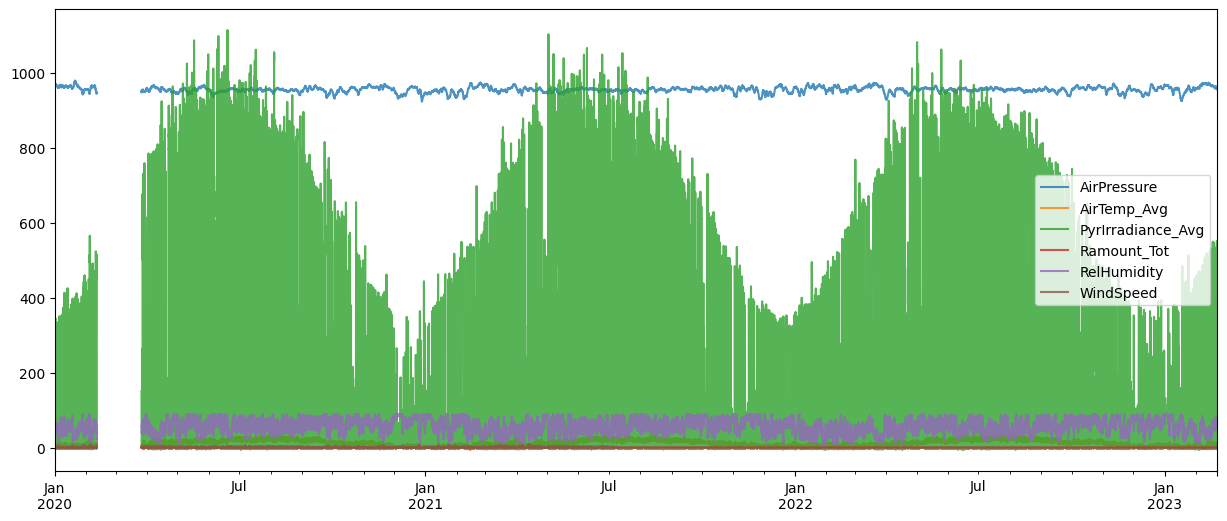

In [15]:
df_meteo.plot(figsize=(15, 6), alpha=0.8)

Visualize the data in df_meters

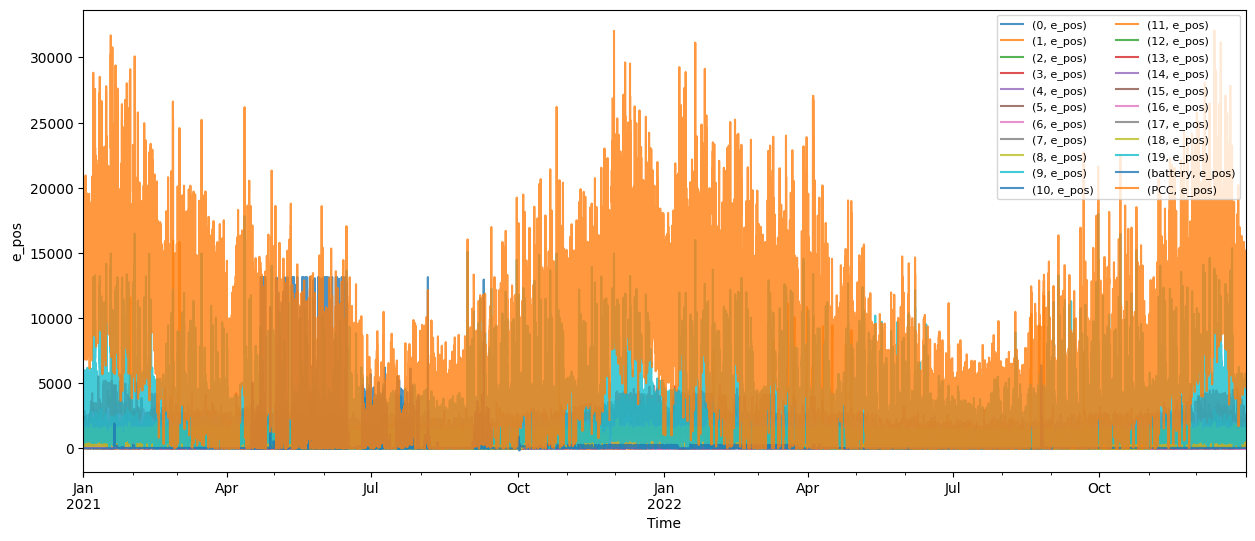

In [16]:
# Plot the e_pos measure in the df_meters dataset
e_pos_cols = [col for col in df_meters.columns if 'e_pos' in col]

# Plot the e_pos columns against the DataFrame's index
df_meters[e_pos_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_pos')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

df_meters_old = df_meters.copy()  # Save for later

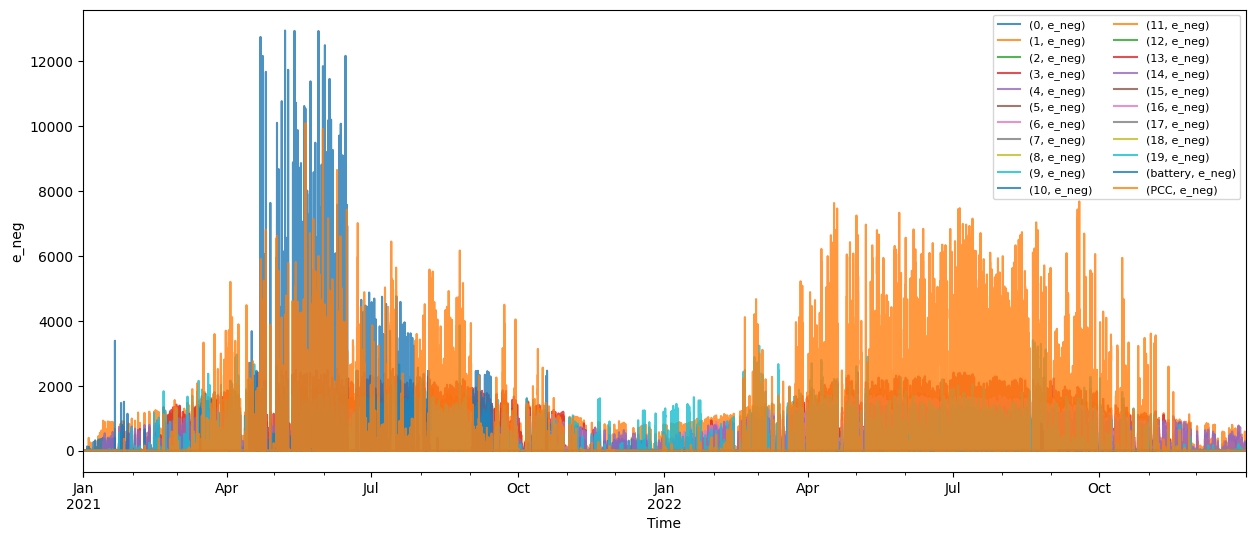

In [17]:
# Plot the e_neg measure in the df_meters dataset
e_neg_cols = [col for col in df_meters.columns if 'e_neg' in col]

# Plot the e_neg columns against the DataFrame's index
df_meters[e_neg_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

Visualize the data in df_nwp

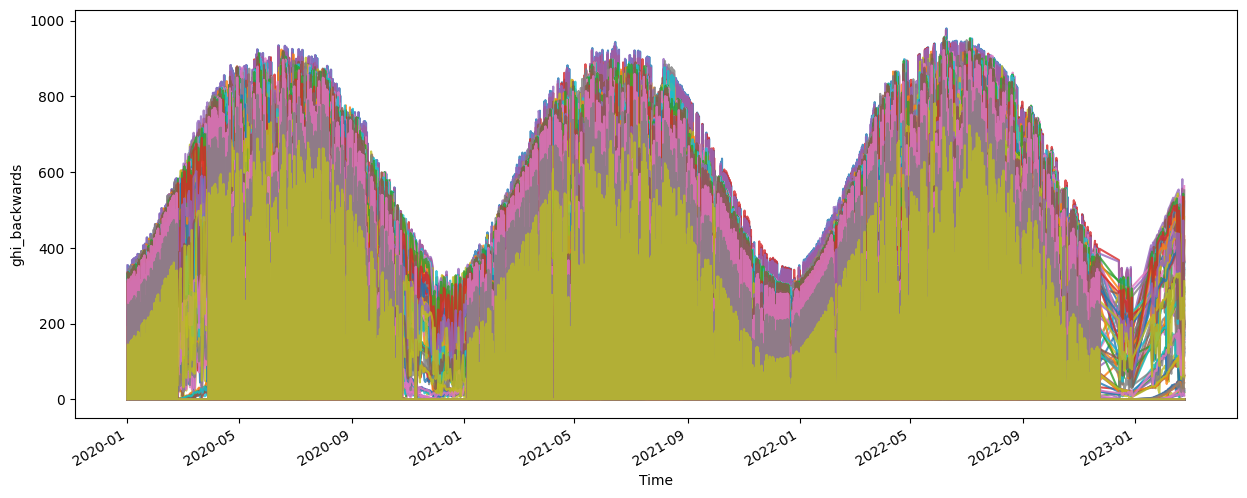

In [18]:
# Plot the ghi_backwards measure in the df_nwp dataset
e_ghi_cols = [col for col in df_nwp.columns if 'ghi_backwards' in col]

# Plot the ghi_backwards columns against the DataFrame's index
df_nwp[e_ghi_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('ghi_backwards')
plt.legend('', frameon=False)
# plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

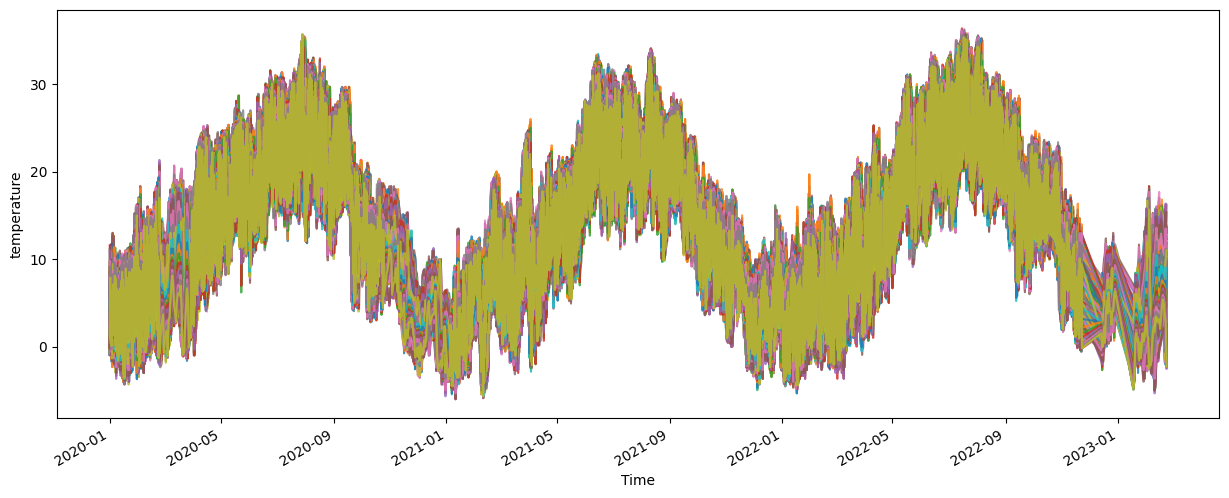

In [19]:
# Plot the temperature measure in the df_nwp dataset
e_temp_cols = [col for col in df_nwp.columns if 'temperature' in col]

# Plot the temperature columns against the DataFrame's index
df_nwp[e_temp_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('temperature')
plt.legend('', frameon=False)
# plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

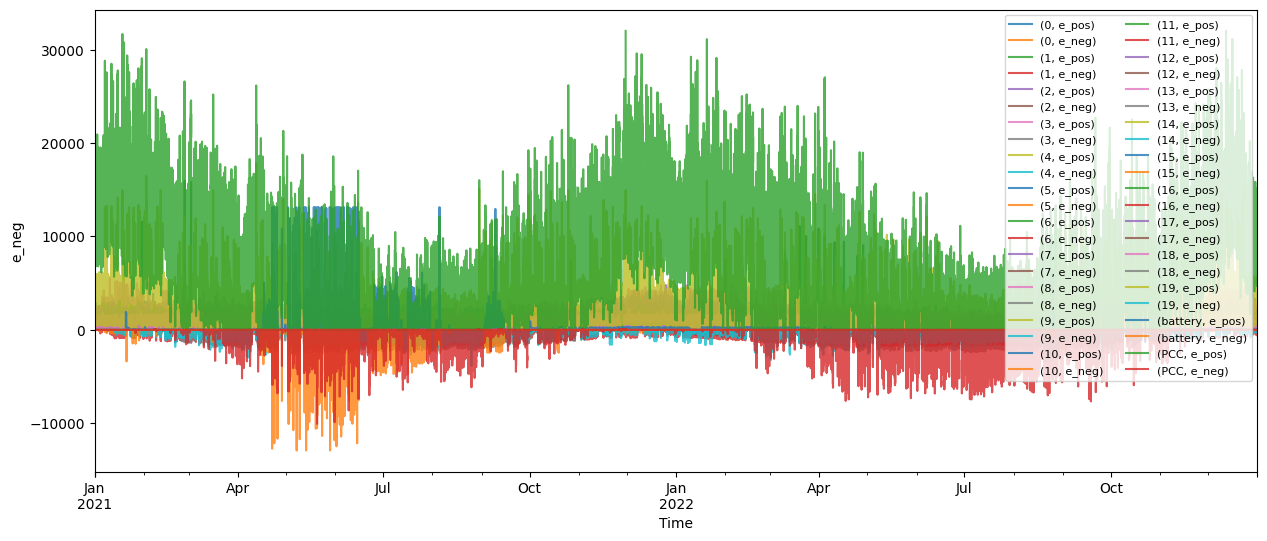

In [20]:
df = df_meters.copy()
df[e_neg_cols] = -df[e_neg_cols]

df.plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

In [21]:
# TODO:
# - Check stationarity
# - Check seasonality
# - Check autocorrelation
# Do some box plots of the features (maybe)

# Clean the data

Comments on the data after having explored it:
- It is requested to resample the data at hourly rate
- It is requested to sum-up the battery data to the PCC data as the energy stored in the battery, as there is a discrepancy with the meters data.

In [22]:
# Check for missing values
print('df_meters:\n', df_meters.isna().sum().sum(), '\n---------\n')

print('df_meteo:\n', df_meteo.isna().sum().sum(), '\n---------\n')

print('df_nwp:\n', df_nwp.isna().sum().sum(), '\n---------\n')

df_meters:
 1269 
---------

df_meteo:
 26022 
---------

df_nwp:
 0 
---------



In [23]:
# Check the shapes of the datasets
print('df_meters:\n', df_meters.shape, '\n---------\n')

print('df_meteo:\n', df_meteo.shape, '\n---------\n')

print('df_nwp:\n', df_nwp.shape, '\n---------\n')

df_meters:
 (70080, 44) 
---------

df_meteo:
 (110208, 6) 
---------

df_nwp:
 (2024, 507) 
---------



## Visualize the position of the missing values

<Axes: >

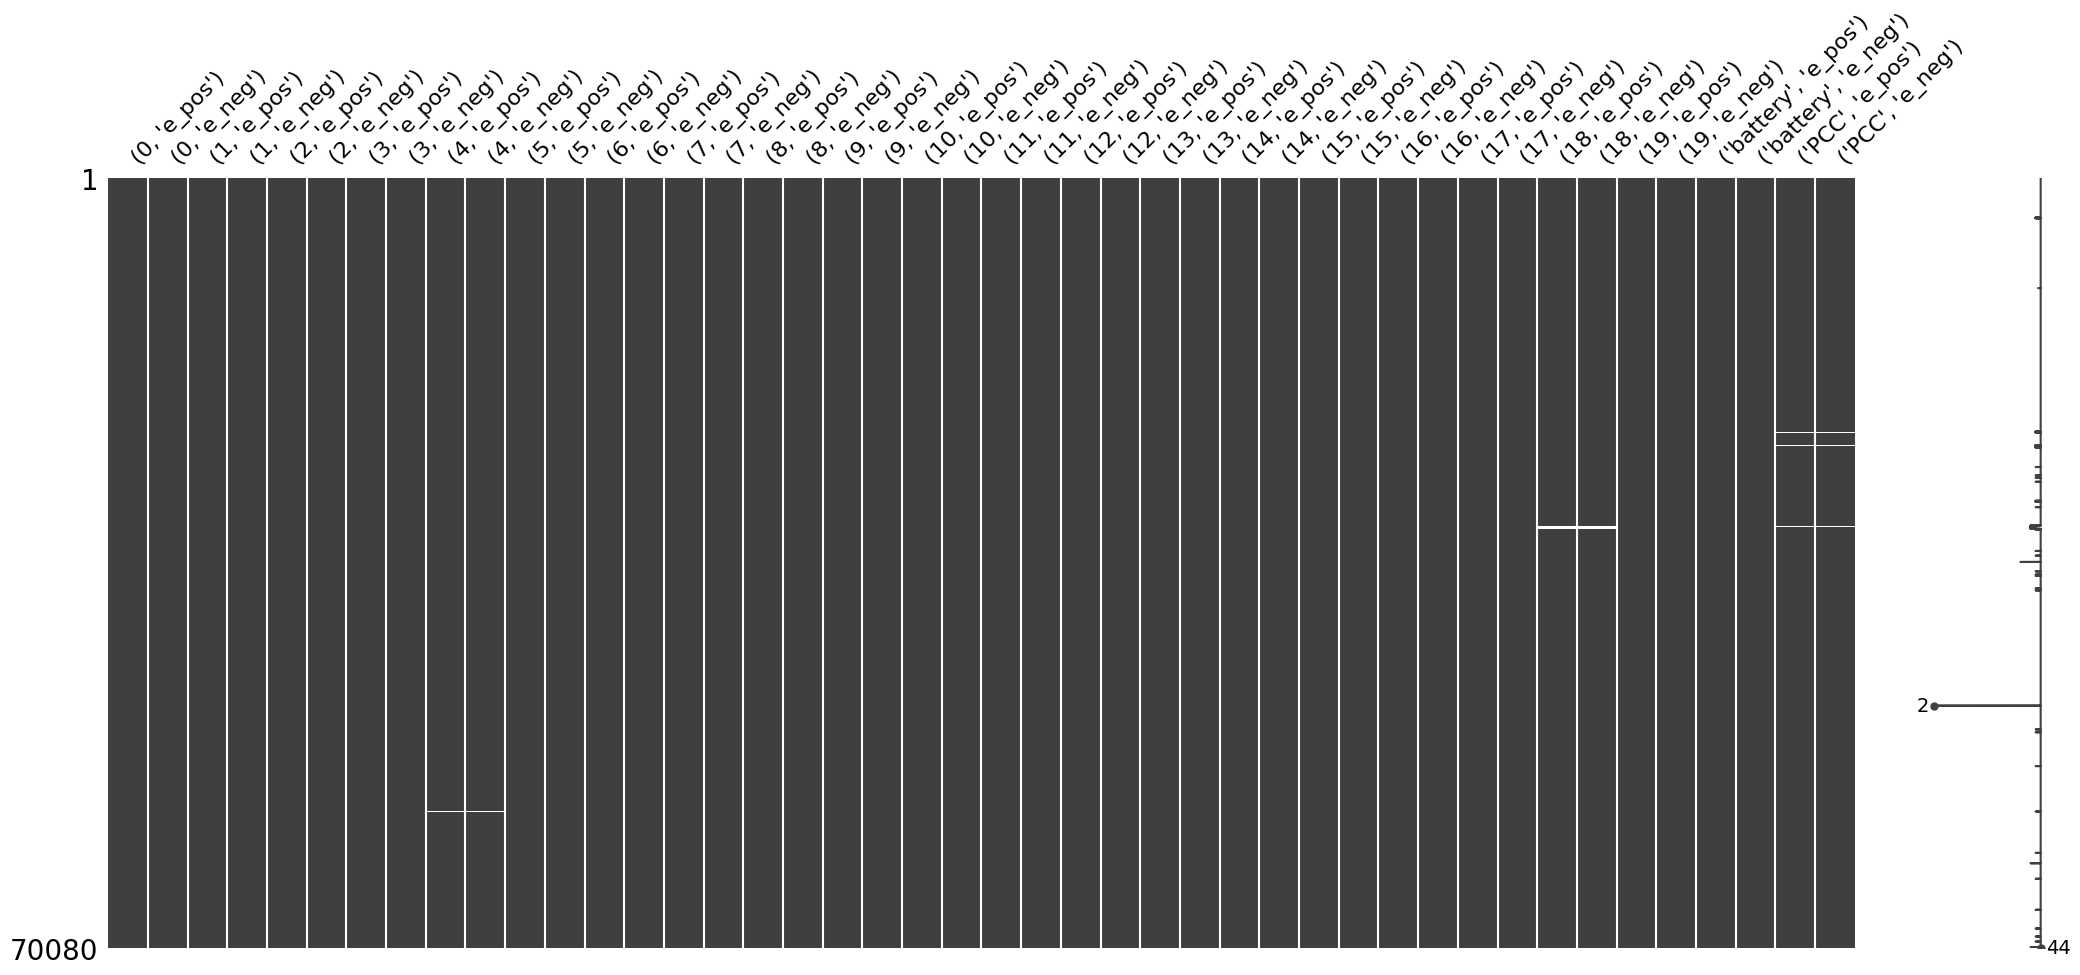

In [24]:
# Visualize the position of null values in the time series of df_meters
msno.matrix(df_meters)

<Axes: >

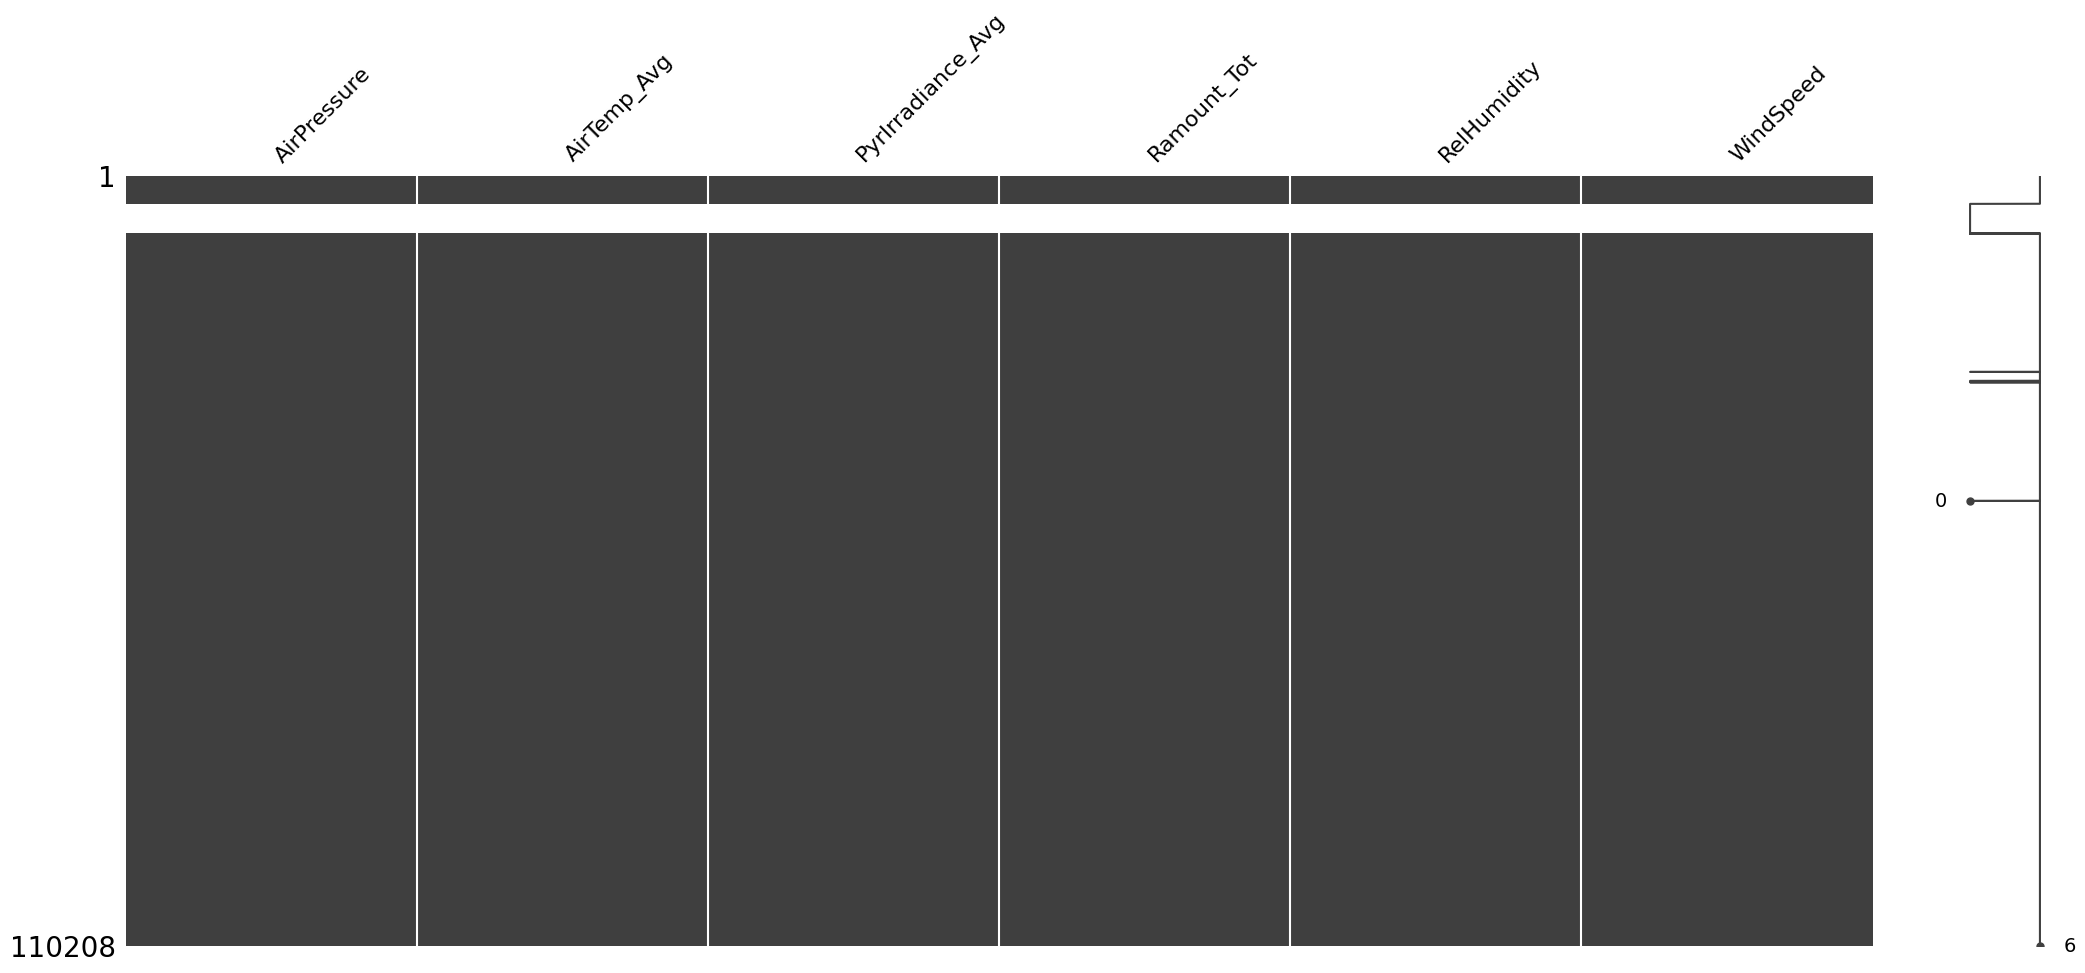

In [25]:
# Visualize the position of null values in the time series of df_meteo
msno.matrix(df_meteo)

<Axes: >

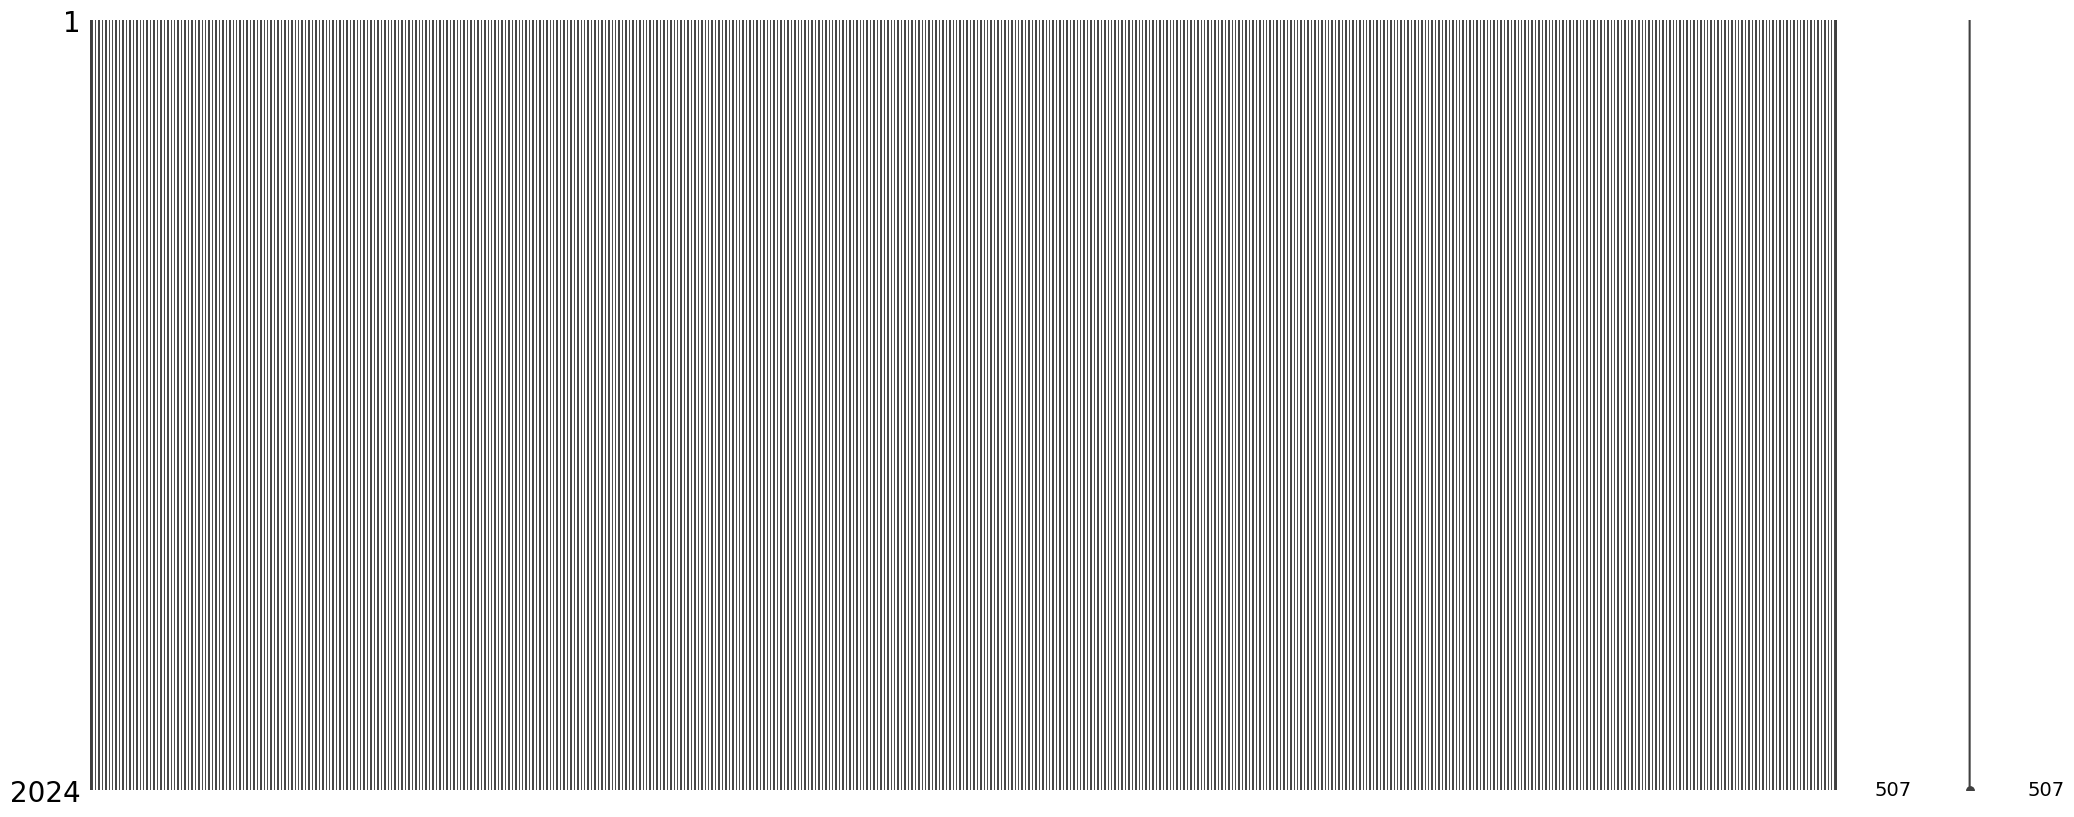

In [26]:
# Visualize the position of null values in the time series of df_nwp
msno.matrix(df_nwp)

## Resample the data at hourly rate

In [27]:
# Check data sampled at 15 minutes intervals in df_meteo
df_meteo.head(3)

AirPressure  AirTemp_Avg  PyrIrradiance_Avg   
2020-01-01 00:00:00+00:00   965.453333     5.613533          -2.768667  \
2020-01-01 00:15:00+00:00   965.460000     5.544867          -2.425200   
2020-01-01 00:30:00+00:00   965.353333     5.549267          -2.498133   

                           Ramount_Tot  RelHumidity  WindSpeed  
2020-01-01 00:00:00+00:00          0.0    48.806667   0.617600  
2020-01-01 00:15:00+00:00          0.0    49.060000   1.238600  
2020-01-01 00:30:00+00:00          0.0    48.820000   0.854533

In [28]:
# Check data sampled at 15 minutes intervals in df_meters
df_meters.head(3)

0            1            2            3         
                           e_pos e_neg  e_pos e_neg  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  126.0   0.0  974.0   0.0  544.0   0.0  681.0   0.0  \
2020-12-31 23:15:00+00:00  102.0   0.0  211.0   0.0  495.0   0.0  606.0   0.0   
2020-12-31 23:30:00+00:00  121.0   0.0  210.0   0.0  233.0   0.0  598.0   0.0   

                                    4        ...     17           18         
                                e_pos e_neg  ...  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  142.000000   0.0  ...  670.0   0.0  808.0   0.0  \
2020-12-31 23:15:00+00:00  663.000000   0.0  ...  525.0   0.0  513.0   0.0   
2020-12-31 23:30:00+00:00  437.167377   0.0  ...  499.0   0.0  436.0   0.0   

                               19       battery            PCC        
                            e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00  1805.0   0.0     1.0   0.0   9142.0   0.0  
2020-12-31 23:15:00+00:00  3082.0   0.0     0.0   0.0  13330.0   0.0  
2020-12-31 23:30:00+00:00   881.0   0.0     1.0   0.0   9095.0   0.0  

[3 rows x 44 columns]

In [29]:
# Resample the data at hourly rate
df_meteo = df_meteo.resample('H').mean()  # Get average meteo values at hourly rate
df_meters = df_meters.resample('H').sum()  # Sum the measurements of meters to get hourly values
# df_nwp = df_nwp.resample('H').interpolate(method='linear')  # Interpolate prediction values to get hourly values

In [30]:
# Check data sampled at 1 hour intervals in df_meeto
df_meteo.head(3)

AirPressure  AirTemp_Avg  PyrIrradiance_Avg   
2020-01-01 00:00:00+00:00   965.396667     5.586717          -2.524517  \
2020-01-01 01:00:00+00:00   965.388333     5.911933          -2.392700   
2020-01-01 02:00:00+00:00   965.216667     6.480783          -2.452333   

                           Ramount_Tot  RelHumidity  WindSpeed  
2020-01-01 00:00:00+00:00          0.0    48.945000   0.908617  
2020-01-01 01:00:00+00:00          0.0    47.821667   0.877183  
2020-01-01 02:00:00+00:00          0.0    45.773333   1.068467

In [31]:
# Check data sampled at 1 hour intervals in df_meters
df_meters.head(3)

0             1             2             3   
                           e_pos e_neg   e_pos e_neg   e_pos e_neg   e_pos   
2020-12-31 23:00:00+00:00  447.0   0.0  1686.0   0.0  1721.0   0.0  2509.0  \
2021-01-01 00:00:00+00:00  485.0   0.0   810.0   0.0  1862.0   0.0  2469.0   
2021-01-01 01:00:00+00:00  218.0   0.0  1433.0   0.0  1679.0   0.0  2330.0   

                                           4        ...      17            18   
                          e_neg        e_pos e_neg  ...   e_pos e_neg   e_pos   
2020-12-31 23:00:00+00:00   0.0  1628.982403   0.0  ...  2389.0   0.0  2119.0  \
2021-01-01 00:00:00+00:00   0.0  1445.581219   0.0  ...  3317.0   0.0  1984.0   
2021-01-01 01:00:00+00:00   0.0  1317.436378   0.0  ...  3390.0   0.0  1639.0   

                                     19       battery            PCC        
                          e_neg   e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00   0.0  6427.0   0.0     3.0   0.0  40947.0   0.0  
2021-01-01 00:00:00+00:00   0.0  6266.0   0.0     2.0   0.0  37873.0   0.0  
2021-01-01 01:00:00+00:00   0.0  7146.0   0.0     3.0   0.0  40145.0   0.0  

[3 rows x 44 columns]

In [32]:
# We slice the data from '2020-12-31 23:00:00+00:00' to '2022-11-28 22:00:00+00:00' so that we have full data fro all the datasets
start_date = '2021-01-01 00:00:00+00:00'

end_date = '2022-11-28 22:00:00+00:00'

df_meteo = df_meteo.loc[start_date:end_date]
df_meters= df_meters.loc[start_date:end_date]
df_nwp = df_nwp.loc[start_date:end_date]

# sort the columns in the multiindex
sorted_nwp = df_nwp.sort_index(axis=1, level=[0, 1])

In [33]:
sorted_nwp.head(3)

ghi_backwards                                      
                                    0    1    2    3    4    5    6    7     
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  \
2021-01-02 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-03 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                         ... temperature                     
                             8      9    ...         159   160   161   162   
2021-01-01 00:00:00+00:00  13.60  45.82  ...        3.91  2.65  1.47  0.46  \
2021-01-02 00:00:00+00:00  12.95  54.19  ...        2.79  1.40  0.20 -0.97   
2021-01-03 00:00:00+00:00   6.86   5.70  ...        3.67  2.91  2.34  1.89   

                                                               
                            163   164   165   166   167   168  
2021-01-01 00:00:00+00:00 -0.31 -0.74 -0.97 -1.27 -1.62 -1.85  
2021-01-02 00:00:00+00:00 -1.91 -2.71 -3.38 -4.05 -3.93 -3.54  
2021-01-03 00:00:00+00:00  1.57  1.34  1.09  0.76  0.35 -0.24  

[3 rows x 507 columns]

In [34]:
# To have hourly samples in df_nwp we use its predictions for the next hours 

def create_empty_hourly_df(start_date, end_date):
    hourly_df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='H'),
                                columns=range(24))
    return hourly_df

def get_hourly(df_preds, df_hourly):
    for i in range(len(df_hourly)):
        time = df_hourly.index[i]
        preds_row = df_preds.loc[df_preds.index <= time].iloc[-1]
        delta = time - preds_row.name  
        hours_diff = delta.total_seconds() / 3600
        df_hourly.iloc[i] = df_preds.loc[df_preds.index <= time].iloc[-1, int(hours_diff):24 + int(hours_diff)].values
    return df_hourly

dfs_list = []
for column in ['ghi_backwards', 'temperature', 'relativehumidity']:
    df = sorted_nwp[column]
    hourly_df = create_empty_hourly_df(start_date, end_date)
    hourly_df = get_hourly(df, hourly_df)
    dfs_list.append(hourly_df)

# concatenate the 3 hourly dfs adding the name of the column as level 1 index of the multiindex
hourly_nwp_df = pd.concat(dfs_list, axis=1, keys=['ghi_backwards', 'temperature', 'relativehumidity'])


In [35]:
df_nwp = hourly_nwp_df
df_nwp

ghi_backwards                                      
                                     0    1    2    3     4      5      6    
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0  \
2021-01-01 01:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2021-01-01 02:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0   13.6   
2021-01-01 03:00:00+00:00           0.0  0.0  0.0  0.0   0.0   13.6  45.82   
2021-01-01 04:00:00+00:00           0.0  0.0  0.0  0.0  13.6  45.82  72.37   
...                                 ...  ...  ...  ...   ...    ...    ...   
2022-11-28 18:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 19:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 20:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 21:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   
2022-11-28 22:00:00+00:00           0.0  0.0  0.0  0.0   0.0    0.0    0.0   

                                                ... relativehumidity          
                              7      8      9   ...               14     15   
2021-01-01 00:00:00+00:00    0.0   13.6  45.82  ...             87.0   92.0  \
2021-01-01 01:00:00+00:00   13.6  45.82  72.37  ...             92.0   98.0   
2021-01-01 02:00:00+00:00  45.82  72.37  59.97  ...             98.0  100.0   
2021-01-01 03:00:00+00:00  72.37  59.97  61.64  ...            100.0   99.0   
2021-01-01 04:00:00+00:00  59.97  61.64  75.82  ...             99.0  100.0   
...                          ...    ...    ...  ...              ...    ...   
2022-11-28 18:00:00+00:00    0.0    0.0    0.0  ...             89.0   79.0   
2022-11-28 19:00:00+00:00    0.0    0.0    0.0  ...             79.0   71.0   
2022-11-28 20:00:00+00:00    0.0    0.0    0.0  ...             71.0   65.0   
2022-11-28 21:00:00+00:00    0.0    0.0    0.0  ...             65.0   61.0   
2022-11-28 22:00:00+00:00    0.0    0.0   1.85  ...             61.0   60.0   

                                                                             
                              16     17     18     19     20     21     22   
2021-01-01 00:00:00+00:00   98.0  100.0   99.0  100.0  100.0  100.0   99.0  \
2021-01-01 01:00:00+00:00  100.0   99.0  100.0  100.0  100.0   99.0  100.0   
2021-01-01 02:00:00+00:00   99.0  100.0  100.0  100.0   99.0  100.0  100.0   
2021-01-01 03:00:00+00:00  100.0  100.0  100.0   99.0  100.0  100.0  100.0   
2021-01-01 04:00:00+00:00  100.0  100.0   99.0  100.0  100.0  100.0  100.0   
...                          ...    ...    ...    ...    ...    ...    ...   
2022-11-28 18:00:00+00:00   71.0   65.0   61.0   60.0   64.0   72.0   80.0   
2022-11-28 19:00:00+00:00   65.0   61.0   60.0   64.0   72.0   80.0   85.0   
2022-11-28 20:00:00+00:00   61.0   60.0   64.0   72.0   80.0   85.0   86.0   
2022-11-28 21:00:00+00:00   60.0   64.0   72.0   80.0   85.0   86.0   87.0   
2022-11-28 22:00:00+00:00   64.0   72.0   80.0   85.0   86.0   87.0   87.0   

                                  
                              23  
2021-01-01 00:00:00+00:00  100.0  
2021-01-01 01:00:00+00:00  100.0  
2021-01-01 02:00:00+00:00  100.0  
2021-01-01 03:00:00+00:00  100.0  
2021-01-01 04:00:00+00:00  100.0  
...                          ...  
2022-11-28 18:00:00+00:00   85.0  
2022-11-28 19:00:00+00:00   86.0  
2022-11-28 20:00:00+00:00   87.0  
2022-11-28 21:00:00+00:00   87.0  
2022-11-28 22:00:00+00:00   86.0  

[16727 rows x 72 columns]

## Sum up the battery data to the PCC data

We had to do it because it happens that sometimes the battery starts storing and providing energy to the stations

In [36]:
# Check PCC data
df_meters['PCC'].head(3)

e_pos  e_neg
2021-01-01 00:00:00+00:00  37873.0    0.0
2021-01-01 01:00:00+00:00  40145.0    0.0
2021-01-01 02:00:00+00:00  35965.0    0.0

In [37]:
# Check battery data
df_meters['battery'].head(3)

e_pos  e_neg
2021-01-01 00:00:00+00:00    2.0    0.0
2021-01-01 01:00:00+00:00    3.0    0.0
2021-01-01 02:00:00+00:00    2.0    0.0

In [38]:
# Duplicate the column PCC to then sum it up with the battery data
new_columns = pd.DataFrame(df_meters['PCC'].values, index=df_meters['PCC'].index, 
                           columns=[('PCC_batt', 'e_pos'), ('PCC_batt', 'e_neg')])
df_meters = pd.concat([df_meters, new_columns], axis=1)

In [39]:
# Check if the new 'PCC_batt' column was added
df_meters.columns[-5]

('battery', 'e_neg')

In [40]:
# Fortunately the data is aligned, so we can simply sum the features
# Sum up battery and PCC data
df_meters[('PCC_batt', 'e_pos')] += df_meters[('battery', 'e_pos')]
df_meters[('PCC_batt', 'e_neg')] += df_meters[('battery', 'e_neg')]

In [41]:
 # Check that the sum was successful
df_meters[['PCC', 'battery', 'PCC_batt']].head(3)

# We'll keep the old columns 'PCC' and 'battery' in case we'll need them later

PCC       battery       PCC_batt      
                             e_pos e_neg   e_pos e_neg    e_pos e_neg
2021-01-01 00:00:00+00:00  37873.0   0.0     2.0   0.0  37875.0   0.0
2021-01-01 01:00:00+00:00  40145.0   0.0     3.0   0.0  40148.0   0.0
2021-01-01 02:00:00+00:00  35965.0   0.0     2.0   0.0  35967.0   0.0

## Impute the missing values on df_meters

In [42]:
# Check for nulls in the datasets
print('df_meters:\n', df_meters.isna().sum().sum(), '\n---------\n')

print('df_meteo:\n', df_meteo.isna().sum().sum(), '\n---------\n')

print('df_nwp:\n', df_nwp.isna().sum().sum(), '\n---------\n')

df_meters:
 0 
---------

df_meteo:
 0 
---------

df_nwp:
 0 
---------



<Axes: >

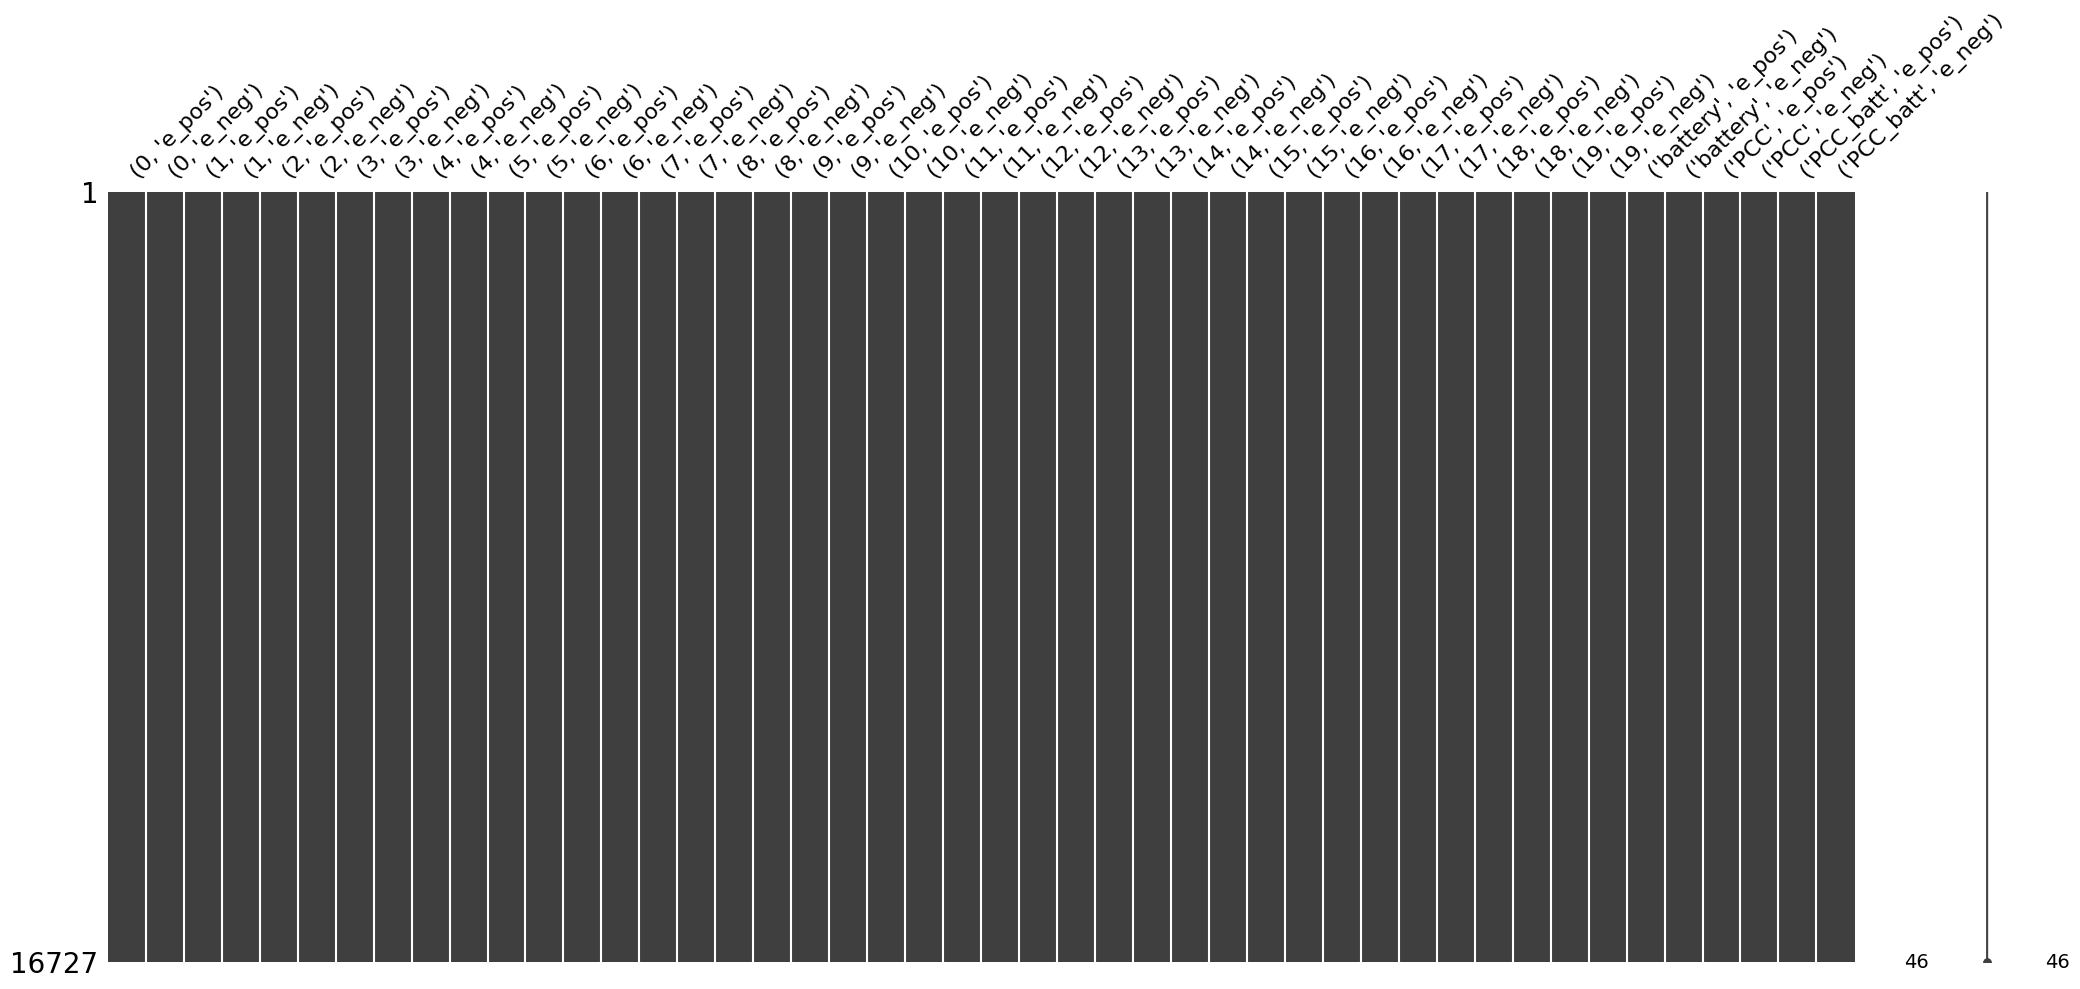

In [43]:
# Visualize the position of the missing values 
msno.matrix(df_meters)

In [44]:
# Impute missing values with the mean
print('Nulls before numerical features imputation:', df_meters.isna().sum().sum())

df_meters = df_meters.fillna(df_meters.mean())

print('Nulls after numerical features imputation:', df_meters.isna().sum().sum())

Nulls before numerical features imputation: 0
Nulls after numerical features imputation: 0


## Remove the multi index

It is not very intuitive to work with a multi-index dataframe, so we'll convert it to a single index dataframe

In [45]:
# Check initial state of df_meters
df_meters.head(1)

0            1             2             3   
                           e_pos e_neg  e_pos e_neg   e_pos e_neg   e_pos   
2021-01-01 00:00:00+00:00  485.0   0.0  810.0   0.0  1862.0   0.0  2469.0  \

                                           4        ...      18            19   
                          e_neg        e_pos e_neg  ...   e_pos e_neg   e_pos   
2021-01-01 00:00:00+00:00   0.0  1445.581219   0.0  ...  1984.0   0.0  6266.0  \

                                battery            PCC       PCC_batt        
                          e_neg   e_pos e_neg    e_pos e_neg    e_pos e_neg  
2021-01-01 00:00:00+00:00   0.0     2.0   0.0  37873.0   0.0  37875.0   0.0  

[1 rows x 46 columns]

In [46]:
# Check initial state of df_nwp
df_nwp.head(1)

ghi_backwards                                      
                                     0    1    2    3    4    5    6    7    
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  \

                                        ... relativehumidity               
                             8      9   ...               14    15    16   
2021-01-01 00:00:00+00:00  13.6  45.82  ...             87.0  92.0  98.0  \

                                                                          
                              17    18     19     20     21    22     23  
2021-01-01 00:00:00+00:00  100.0  99.0  100.0  100.0  100.0  99.0  100.0  

[1 rows x 72 columns]

In [47]:
# Remove the multi index from df_meters and df_nwp
# df_meteo already has no multi index
df_meters_multi = df_meters
df_meters.columns = [f'{col[1]}_{col[0]}' for col in df_meters.columns]
df_nwp.columns = [f'{col[1]}_{col[0]}' for col in df_nwp.columns]

In [48]:
# Check result on df_meters
df_meters.head(1)

e_pos_0  e_neg_0  e_pos_1  e_neg_1  e_pos_2   
2021-01-01 00:00:00+00:00    485.0      0.0    810.0      0.0   1862.0  \

                           e_neg_2  e_pos_3  e_neg_3      e_pos_4  e_neg_4   
2021-01-01 00:00:00+00:00      0.0   2469.0      0.0  1445.581219      0.0  \

                           ...  e_pos_18  e_neg_18  e_pos_19  e_neg_19   
2021-01-01 00:00:00+00:00  ...    1984.0       0.0    6266.0       0.0  \

                           e_pos_battery  e_neg_battery  e_pos_PCC  e_neg_PCC   
2021-01-01 00:00:00+00:00            2.0            0.0    37873.0        0.0  \

                           e_pos_PCC_batt  e_neg_PCC_batt  
2021-01-01 00:00:00+00:00         37875.0             0.0  

[1 rows x 46 columns]

In [49]:
# Check result on df_nwp
df_nwp.head(1)

0_ghi_backwards 1_ghi_backwards 2_ghi_backwards   
2021-01-01 00:00:00+00:00             0.0             0.0             0.0  \

                          3_ghi_backwards 4_ghi_backwards 5_ghi_backwards   
2021-01-01 00:00:00+00:00             0.0             0.0             0.0  \

                          6_ghi_backwards 7_ghi_backwards 8_ghi_backwards   
2021-01-01 00:00:00+00:00             0.0             0.0            13.6  \

                          9_ghi_backwards  ... 14_relativehumidity   
2021-01-01 00:00:00+00:00           45.82  ...                87.0  \

                          15_relativehumidity 16_relativehumidity   
2021-01-01 00:00:00+00:00                92.0                98.0  \

                          17_relativehumidity 18_relativehumidity   
2021-01-01 00:00:00+00:00               100.0                99.0  \

                          19_relativehumidity 20_relativehumidity   
2021-01-01 00:00:00+00:00               100.0               100.0  \

                          21_relativehumidity 22_relativehumidity   
2021-01-01 00:00:00+00:00               100.0                99.0  \

                          23_relativehumidity  
2021-01-01 00:00:00+00:00               100.0  

[1 rows x 72 columns]

## Merge the datasets to get a single dataset with all the features
Some data has different time windows, so there will be some NaN values.
We decided to drop the windows where we don't have data from all the features.

In [50]:
# Check the range of dates in the three datasets
print('Start date:\n',
      'df_meters:', df_meters.index.min(), '\n',
      'df_meteo:', df_meteo.index.min(), '\n',
      'df_nwp:', df_nwp.index.min(), '\n')
      
print('End date:\n',
      'df_meters:', df_meters.index.max(), '\n',
      'df_meteo:', df_meteo.index.max(), '\n',
      'df_nwp:', df_nwp.index.max())

Start date:
 df_meters: 2021-01-01 00:00:00+00:00 
 df_meteo: 2021-01-01 00:00:00+00:00 
 df_nwp: 2021-01-01 00:00:00+00:00 

End date:
 df_meters: 2022-11-28 22:00:00+00:00 
 df_meteo: 2022-11-28 22:00:00+00:00 
 df_nwp: 2022-11-28 22:00:00+00:00


In [51]:
df = pd.concat([df_meters, df_meteo, df_nwp], axis=1)

In [52]:
df.shape

(16727, 124)

In [53]:
df.head(3)

e_pos_0  e_neg_0  e_pos_1  e_neg_1  e_pos_2   
2021-01-01 00:00:00+00:00    485.0      0.0    810.0      0.0   1862.0  \
2021-01-01 01:00:00+00:00    218.0      0.0   1433.0      0.0   1679.0   
2021-01-01 02:00:00+00:00    224.0      0.0   2046.0      0.0   1749.0   

                           e_neg_2  e_pos_3  e_neg_3      e_pos_4  e_neg_4   
2021-01-01 00:00:00+00:00      0.0   2469.0      0.0  1445.581219      0.0  \
2021-01-01 01:00:00+00:00      0.0   2330.0      0.0  1317.436378      0.0   
2021-01-01 02:00:00+00:00      0.0   2457.0      0.0  1185.000000      0.0   

                           ...  14_relativehumidity  15_relativehumidity   
2021-01-01 00:00:00+00:00  ...                 87.0                 92.0  \
2021-01-01 01:00:00+00:00  ...                 92.0                 98.0   
2021-01-01 02:00:00+00:00  ...                 98.0                100.0   

                           16_relativehumidity  17_relativehumidity   
2021-01-01 00:00:00+00:00                 98.0                100.0  \
2021-01-01 01:00:00+00:00                100.0                 99.0   
2021-01-01 02:00:00+00:00                 99.0                100.0   

                           18_relativehumidity  19_relativehumidity   
2021-01-01 00:00:00+00:00                 99.0                100.0  \
2021-01-01 01:00:00+00:00                100.0                100.0   
2021-01-01 02:00:00+00:00                100.0                100.0   

                           20_relativehumidity  21_relativehumidity   
2021-01-01 00:00:00+00:00                100.0                100.0  \
2021-01-01 01:00:00+00:00                100.0                 99.0   
2021-01-01 02:00:00+00:00                 99.0                100.0   

                           22_relativehumidity  23_relativehumidity  
2021-01-01 00:00:00+00:00                 99.0                100.0  
2021-01-01 01:00:00+00:00                100.0                100.0  
2021-01-01 02:00:00+00:00                100.0                100.0  

[3 rows x 124 columns]

## Sum up the data about station 10 and 11

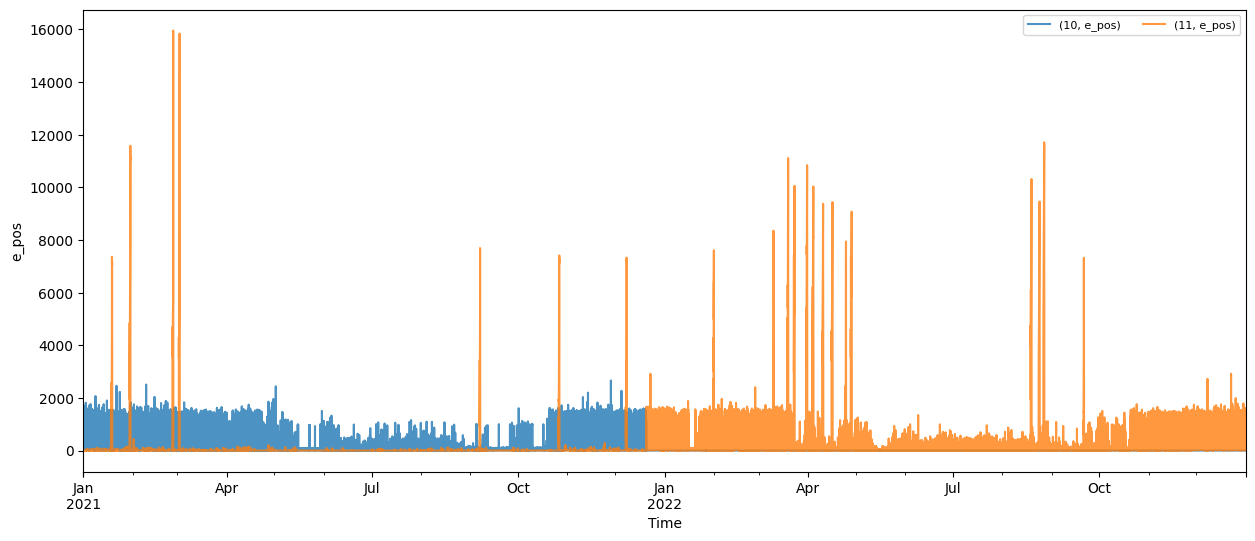

In [54]:
# The data in station 10 and 11 seem to be from the same source/people who changed station, so we'll sum them up
df_meters_old[e_pos_cols[10:12]].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_pos')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

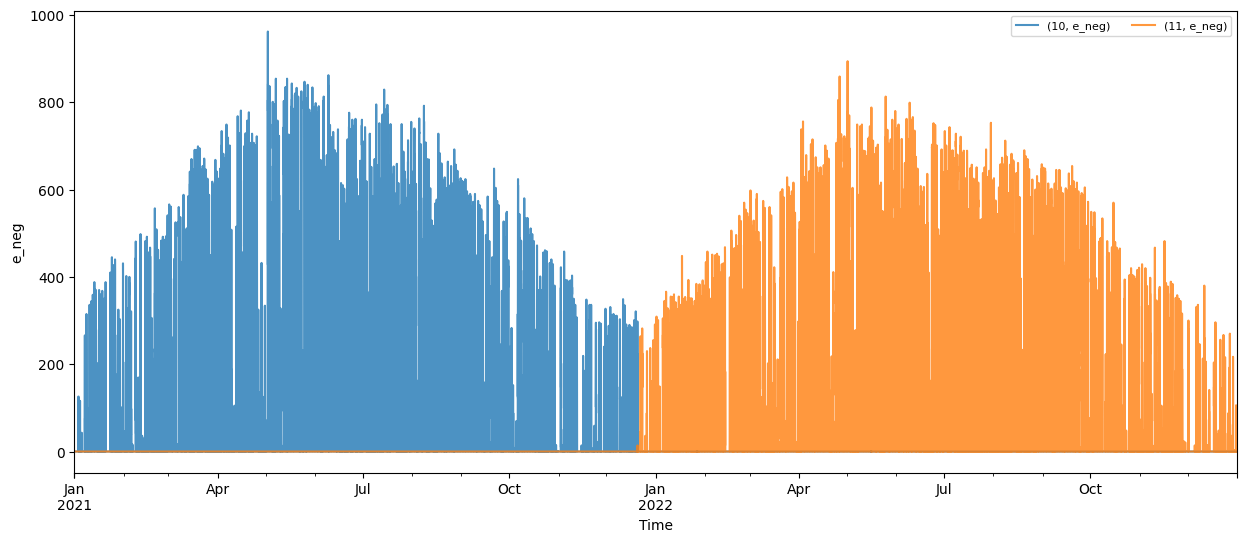

In [55]:
df_meters_old[e_neg_cols[10:12]].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

In [56]:
# Identify the date in which the two stations were swapped
trial_pos = df_meters_old[e_pos_cols[10:12]]
trial_neg = df_meters_old[e_neg_cols[10:12]]

In [57]:
trial_pos = trial_pos.reset_index()
trial_neg = trial_neg.reset_index()

In [58]:
# Get the number of samples in december 2021
trial_pos[(trial_pos['index'] >= '2021-12-01') & (trial_pos['index'] < '2022-01-01')].shape

(2976, 3)

In [59]:
# Inspect e_pos values in december 2021
trial_pos[(trial_pos['index'] >= '2021-12-01') & (trial_pos['index'] < '2022-01-01')][1870:1885]

index    10      11
                                e_pos   e_pos
33938 2021-12-20 11:30:00+00:00   0.0     0.0
33939 2021-12-20 11:45:00+00:00   0.0     0.0
33940 2021-12-20 12:00:00+00:00   0.0     0.0
33941 2021-12-20 12:15:00+00:00   0.0     0.0
33942 2021-12-20 12:30:00+00:00   6.0     0.0
33943 2021-12-20 12:45:00+00:00   0.0     0.0
33944 2021-12-20 13:00:00+00:00   0.0     NaN
33945 2021-12-20 13:15:00+00:00   0.0     NaN
33946 2021-12-20 13:30:00+00:00   0.0     NaN
33947 2021-12-20 13:45:00+00:00   0.0    14.0
33948 2021-12-20 14:00:00+00:00   0.0   681.0
33949 2021-12-20 14:15:00+00:00   0.0  1659.0
33950 2021-12-20 14:30:00+00:00   0.0   786.0
33951 2021-12-20 14:45:00+00:00   0.0   216.0
33952 2021-12-20 15:00:00+00:00   0.0   370.0

In [60]:
# Inspect e_neg values in december 2021
trial_neg[(trial_neg['index'] >= '2021-12-01') & (trial_neg['index'] < '2022-01-01')][1870:1885]

index     10    11
                                 e_neg e_neg
33938 2021-12-20 11:30:00+00:00  290.0   0.0
33939 2021-12-20 11:45:00+00:00  298.0   0.0
33940 2021-12-20 12:00:00+00:00  288.0   0.0
33941 2021-12-20 12:15:00+00:00  275.0   0.0
33942 2021-12-20 12:30:00+00:00  238.0   0.0
33943 2021-12-20 12:45:00+00:00  211.0   0.0
33944 2021-12-20 13:00:00+00:00    0.0   NaN
33945 2021-12-20 13:15:00+00:00    0.0   NaN
33946 2021-12-20 13:30:00+00:00    0.0   NaN
33947 2021-12-20 13:45:00+00:00    0.0   0.0
33948 2021-12-20 14:00:00+00:00    0.0  14.0
33949 2021-12-20 14:15:00+00:00    0.0   0.0
33950 2021-12-20 14:30:00+00:00    0.0   0.0
33951 2021-12-20 14:45:00+00:00    0.0   0.0
33952 2021-12-20 15:00:00+00:00    0.0   0.0

In [61]:
# The switch happens in the days around '2021-12-20 13:00:00+00:00'

# Add Date column to the dataframe
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])

# Set e_pos_10 and e_neg_10 to 0 when Date > '2021-12-20 13:00:00+00:00'
df.loc[df['Date'] > pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_10', 'e_neg_10']] = 0

# Set e_pos_11 and e_neg_11 to 0 when Date < '2021-12-20 13:00:00+00:00'
df.loc[df['Date'] < pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_11', 'e_neg_11']] = 0

# Adjust the dataset
df['e_neg_10'] = df['e_neg_11']
df['e_pos_10'] = df['e_pos_11']
df =df.drop(columns=['e_pos_11', 'e_neg_11'])
for i in range(12, 20):
    df = df.rename(columns={
        f"e_pos_{i}": f"e_pos_{i-1}",
        f"e_neg_{i}": f"e_neg_{i-1}",
    })


df.head(3)

Date  e_pos_0  e_neg_0  e_pos_1  e_neg_1  e_pos_2   
0 2021-01-01 00:00:00+00:00    485.0      0.0    810.0      0.0   1862.0  \
1 2021-01-01 01:00:00+00:00    218.0      0.0   1433.0      0.0   1679.0   
2 2021-01-01 02:00:00+00:00    224.0      0.0   2046.0      0.0   1749.0   

   e_neg_2  e_pos_3  e_neg_3      e_pos_4  ...  14_relativehumidity   
0      0.0   2469.0      0.0  1445.581219  ...                 87.0  \
1      0.0   2330.0      0.0  1317.436378  ...                 92.0   
2      0.0   2457.0      0.0  1185.000000  ...                 98.0   

   15_relativehumidity  16_relativehumidity  17_relativehumidity   
0                 92.0                 98.0                100.0  \
1                 98.0                100.0                 99.0   
2                100.0                 99.0                100.0   

   18_relativehumidity  19_relativehumidity  20_relativehumidity   
0                 99.0                100.0                100.0  \
1                100.0                100.0                100.0   
2                100.0                100.0                 99.0   

   21_relativehumidity  22_relativehumidity  23_relativehumidity  
0                100.0                 99.0                100.0  
1                 99.0                100.0                100.0  
2                100.0                100.0                100.0  

[3 rows x 123 columns]

In [62]:
# Do the same on just df_meters because we need it to perform other tasks
# Add Date column to the dataframe
df_meters.reset_index(inplace=True)
df_meters.rename(columns={'index': 'Date'}, inplace=True)

df_meters['Date'] = pd.to_datetime(df_meters['Date'])

# Set e_pos_10 and e_neg_10 to 0 when Date > '2021-12-20 13:00:00+00:00'
df_meters.loc[df_meters['Date'] > pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_10', 'e_neg_10']] = 0

# Set e_pos_11 and e_neg_11 to 0 when Date < '2021-12-20 13:00:00+00:00'
df_meters.loc[df_meters['Date'] < pd.to_datetime('2021-12-20 13:00:00+00:00'), ['e_pos_11', 'e_neg_11']] = 0

# Adjust the dataset
df_meters['e_neg_10'] = df_meters['e_neg_11']
df_meters['e_pos_10'] = df_meters['e_pos_11']
df_meters = df_meters.drop(columns=['e_pos_11', 'e_neg_11'])
for i in range(12, 20):
    df_meters = df_meters.rename(columns={
        f"e_pos_{i}": f"e_pos_{i-1}",
        f"e_neg_{i}": f"e_neg_{i-1}",
    })


df_meters.head(3)

Date  e_pos_0  e_neg_0  e_pos_1  e_neg_1  e_pos_2   
0 2021-01-01 00:00:00+00:00    485.0      0.0    810.0      0.0   1862.0  \
1 2021-01-01 01:00:00+00:00    218.0      0.0   1433.0      0.0   1679.0   
2 2021-01-01 02:00:00+00:00    224.0      0.0   2046.0      0.0   1749.0   

   e_neg_2  e_pos_3  e_neg_3      e_pos_4  ...  e_pos_17  e_neg_17  e_pos_18   
0      0.0   2469.0      0.0  1445.581219  ...    1984.0       0.0    6266.0  \
1      0.0   2330.0      0.0  1317.436378  ...    1639.0       0.0    7146.0   
2      0.0   2457.0      0.0  1185.000000  ...    1421.0       0.0    7299.0   

   e_neg_18  e_pos_battery  e_neg_battery  e_pos_PCC  e_neg_PCC   
0       0.0            2.0            0.0    37873.0        0.0  \
1       0.0            3.0            0.0    40145.0        0.0   
2       0.0            2.0            0.0    35965.0        0.0   

   e_pos_PCC_batt  e_neg_PCC_batt  
0         37875.0             0.0  
1         40148.0             0.0  
2         35967.0             0.0  

[3 rows x 45 columns]

## Get columns e_pos and e_neg containing the concatenatenated values of all the stations

In [63]:
df_new = pd.DataFrame()
df_meters_temp = df_meters.copy()

df_meters_temp.reset_index(inplace=True)
df_meters_temp.rename(columns={'index': 'date'}, inplace=True)

for i in range(19):
    if i == 0:
        df_new[f'e_pos'] = df_meters_temp[f'e_pos_{i}']
        df_new[f'e_neg'] = df_meters_temp[f'e_neg_{i}']
        df_new['unique_id'] = i
        df_new['ds'] = df_meters_temp['date']
    else:
        df_loop = pd.DataFrame()
        df_loop[f'e_pos'] = df_meters_temp[f'e_pos_{i}']
        df_loop[f'e_neg'] = df_meters_temp[f'e_neg_{i}']
        df_loop['unique_id'] = i
        df_loop['ds'] = df_meters_temp['date']
        df_new = pd.concat([df_new, df_loop], axis=0)

df_new.reset_index(drop=True, inplace=True)
# df_new[df_new['unique_id'] == 1]
df_new.unique_id.unique()

e_pos_series = df_new['e_pos']
e_neg_series = df_new['e_neg']

## Perform outlier detection

## Drop unused columns

In [64]:
# Save the dataset with no rows columns concatenation and before dropping the columns for each station
df_nc = df.copy() 

In [65]:
df_nc

Date  e_pos_0  e_neg_0  e_pos_1  e_neg_1  e_pos_2   
0     2021-01-01 00:00:00+00:00    485.0      0.0    810.0      0.0   1862.0  \
1     2021-01-01 01:00:00+00:00    218.0      0.0   1433.0      0.0   1679.0   
2     2021-01-01 02:00:00+00:00    224.0      0.0   2046.0      0.0   1749.0   
3     2021-01-01 03:00:00+00:00    287.0      0.0   1688.0      0.0   1879.0   
4     2021-01-01 04:00:00+00:00    227.0      0.0   1762.0      0.0   1998.0   
...                         ...      ...      ...      ...      ...      ...   
16722 2022-11-28 18:00:00+00:00    262.0      0.0   2515.0      0.0   2251.0   
16723 2022-11-28 19:00:00+00:00   1037.0      0.0   2458.0      0.0   1263.0   
16724 2022-11-28 20:00:00+00:00    948.0      0.0    637.0      0.0   1235.0   
16725 2022-11-28 21:00:00+00:00    215.0      0.0    464.0      0.0   1191.0   
16726 2022-11-28 22:00:00+00:00    240.0      0.0    778.0      0.0   1054.0   

       e_neg_2  e_pos_3  e_neg_3      e_pos_4  ...  14_relativehumidity   
0          0.0   2469.0      0.0  1445.581219  ...                 87.0  \
1          0.0   2330.0      0.0  1317.436378  ...                 92.0   
2          0.0   2457.0      0.0  1185.000000  ...                 98.0   
3          0.0   2123.0      0.0   558.000000  ...                100.0   
4          0.0   4850.0      0.0   522.000000  ...                 99.0   
...        ...      ...      ...          ...  ...                  ...   
16722      0.0   2948.0      0.0  1903.000000  ...                 89.0   
16723      0.0   3406.0      0.0  1518.000000  ...                 79.0   
16724      0.0   2146.0      0.0  1800.000000  ...                 71.0   
16725      0.0   1159.0      0.0  1059.000000  ...                 65.0   
16726      0.0   1243.0      0.0   497.000000  ...                 61.0   

       15_relativehumidity  16_relativehumidity  17_relativehumidity   
0                     92.0                 98.0                100.0  \
1                     98.0                100.0                 99.0   
2                    100.0                 99.0                100.0   
3                     99.0                100.0                100.0   
4                    100.0                100.0                100.0   
...                    ...                  ...                  ...   
16722                 79.0                 71.0                 65.0   
16723                 71.0                 65.0                 61.0   
16724                 65.0                 61.0                 60.0   
16725                 61.0                 60.0                 64.0   
16726                 60.0                 64.0                 72.0   

       18_relativehumidity  19_relativehumidity  20_relativehumidity   
0                     99.0                100.0                100.0  \
1                    100.0                100.0                100.0   
2                    100.0                100.0                 99.0   
3                    100.0                 99.0                100.0   
4                     99.0                100.0                100.0   
...                    ...                  ...                  ...   
16722                 61.0                 60.0                 64.0   
16723                 60.0                 64.0                 72.0   
16724                 64.0                 72.0                 80.0   
16725                 72.0                 80.0                 85.0   
16726                 80.0                 85.0                 86.0   

       21_relativehumidity  22_relativehumidity  23_relativehumidity  
0                    100.0                 99.0                100.0  
1                     99.0                100.0                100.0  
2                    100.0                100.0                100.0  
3                    100.0                100.0                100.0  
4                    100.0                100.0                100.0  
...      

In [66]:
# Drop all the old e_pos_N and e_neg_N features
df = df.drop(columns=[f'e_pos_{i}' for i in range(19)], axis=1)
df = df.drop(columns=[f'e_neg_{i}' for i in range(19)], axis=1)
df.head(3)

Date  e_pos_battery  e_neg_battery  e_pos_PCC   
0 2021-01-01 00:00:00+00:00            2.0            0.0    37873.0  \
1 2021-01-01 01:00:00+00:00            3.0            0.0    40145.0   
2 2021-01-01 02:00:00+00:00            2.0            0.0    35965.0   

   e_neg_PCC  e_pos_PCC_batt  e_neg_PCC_batt  AirPressure  AirTemp_Avg   
0        0.0         37875.0             0.0   945.905722     0.788833  \
1        0.0         40148.0             0.0   946.249667     0.791278   
2        0.0         35967.0             0.0   946.063833     0.608611   

   PyrIrradiance_Avg  ...  14_relativehumidity  15_relativehumidity   
0          -0.375317  ...                 87.0                 92.0  \
1          -0.553497  ...                 92.0                 98.0   
2          -0.514245  ...                 98.0                100.0   

   16_relativehumidity 17_relativehumidity 18_relativehumidity   
0                 98.0               100.0                99.0  \
1                100.0                99.0               100.0   
2                 99.0               100.0               100.0   

  19_relativehumidity 20_relativehumidity 21_relativehumidity   
0               100.0               100.0               100.0  \
1               100.0               100.0                99.0   
2               100.0                99.0               100.0   

  22_relativehumidity 23_relativehumidity  
0                99.0               100.0  
1               100.0               100.0  
2               100.0               100.0  

[3 rows x 85 columns]

In [67]:
# Drop e_pos_battery, e_neg_battery, e_pos_PCC, e_neg_PCC, as e_pos_PCC_batt and e_neg_PCC_batt are the sum of battery and PCC
df = df.drop(columns=['e_pos_battery', 'e_neg_battery'], axis=1)
df = df.drop(columns=['e_pos_PCC', 'e_neg_PCC'], axis=1)
df.head(3)

Date  e_pos_PCC_batt  e_neg_PCC_batt  AirPressure   
0 2021-01-01 00:00:00+00:00         37875.0             0.0   945.905722  \
1 2021-01-01 01:00:00+00:00         40148.0             0.0   946.249667   
2 2021-01-01 02:00:00+00:00         35967.0             0.0   946.063833   

   AirTemp_Avg  PyrIrradiance_Avg  Ramount_Tot  RelHumidity  WindSpeed   
0     0.788833          -0.375317          0.0    66.748611   0.652444  \
1     0.791278          -0.553497          0.0    63.983167   0.549056   
2     0.608611          -0.514245          0.0    65.924611   0.501333   

  0_ghi_backwards  ... 14_relativehumidity 15_relativehumidity   
0             0.0  ...                87.0                92.0  \
1             0.0  ...                92.0                98.0   
2             0.0  ...                98.0               100.0   

  16_relativehumidity 17_relativehumidity 18_relativehumidity   
0                98.0               100.0                99.0  \
1               100.0                99.0               100.0   
2                99.0               100.0               100.0   

  19_relativehumidity 20_relativehumidity 21_relativehumidity   
0               100.0               100.0               100.0  \
1               100.0               100.0                99.0   
2               100.0                99.0               100.0   

  22_relativehumidity 23_relativehumidity  
0                99.0               100.0  
1               100.0               100.0  
2               100.0               100.0  

[3 rows x 81 columns]

## Add station column 

Add station column to identify stations' values when values are concatenated

In [68]:
# Add the station_id column and replicate the dataset 20 times
num_stations = 19
dim = df.shape[0]

# Replicate the rows of the original dataframe by the number of stations
df = pd.concat([df]*num_stations, ignore_index=True)

# Create a list of station IDs
station_ids = []
for i in range(num_stations):
    station_ids += [str(i)]*dim

# Assign the station IDs to the replicated dataframe
df['station_id'] = station_ids

## Concatenate the e_pos_N and e_neg_N columns into the columns e_pos, e_neg

In [69]:
# Concatenate the e_pos_N and e_neg_N columns into the columns e_pos and e_neg
df['e_pos'] = e_pos_series
df['e_neg'] = e_neg_series
df.head(3)

Date  e_pos_PCC_batt  e_neg_PCC_batt  AirPressure   
0 2021-01-01 00:00:00+00:00         37875.0             0.0   945.905722  \
1 2021-01-01 01:00:00+00:00         40148.0             0.0   946.249667   
2 2021-01-01 02:00:00+00:00         35967.0             0.0   946.063833   

   AirTemp_Avg  PyrIrradiance_Avg  Ramount_Tot  RelHumidity  WindSpeed   
0     0.788833          -0.375317          0.0    66.748611   0.652444  \
1     0.791278          -0.553497          0.0    63.983167   0.549056   
2     0.608611          -0.514245          0.0    65.924611   0.501333   

  0_ghi_backwards  ... 17_relativehumidity 18_relativehumidity   
0             0.0  ...               100.0                99.0  \
1             0.0  ...                99.0               100.0   
2             0.0  ...               100.0               100.0   

  19_relativehumidity 20_relativehumidity 21_relativehumidity   
0               100.0               100.0               100.0  \
1               100.0               100.0                99.0   
2               100.0                99.0               100.0   

  22_relativehumidity 23_relativehumidity station_id  e_pos e_neg  
0                99.0               100.0          0  485.0   0.0  
1               100.0               100.0          0  218.0   0.0  
2               100.0               100.0          0  224.0   0.0  

[3 rows x 84 columns]

In [70]:
# Move 'station_id', 'e_pos', 'e_neg' from the last columns to the first ones after Date

# Get the columns of interest
station_id = df.pop('station_id')
e_pos = df.pop('e_pos')
e_neg = df.pop('e_neg')
e_pos_neg_sum = e_pos - e_neg

# Insert the columns of interest in the first columns after Date
df.insert(1, 'e_pos_neg_sum', e_pos_neg_sum)
df.insert(1, 'station_id', station_id)

df.head(3)

Date station_id  e_pos_neg_sum  e_pos_PCC_batt   
0 2021-01-01 00:00:00+00:00          0          485.0         37875.0  \
1 2021-01-01 01:00:00+00:00          0          218.0         40148.0   
2 2021-01-01 02:00:00+00:00          0          224.0         35967.0   

   e_neg_PCC_batt  AirPressure  AirTemp_Avg  PyrIrradiance_Avg  Ramount_Tot   
0             0.0   945.905722     0.788833          -0.375317          0.0  \
1             0.0   946.249667     0.791278          -0.553497          0.0   
2             0.0   946.063833     0.608611          -0.514245          0.0   

   RelHumidity  ...  14_relativehumidity 15_relativehumidity   
0    66.748611  ...                 87.0                92.0  \
1    63.983167  ...                 92.0                98.0   
2    65.924611  ...                 98.0               100.0   

  16_relativehumidity 17_relativehumidity 18_relativehumidity   
0                98.0               100.0                99.0  \
1               100.0                99.0               100.0   
2                99.0               100.0               100.0   

  19_relativehumidity 20_relativehumidity 21_relativehumidity   
0               100.0               100.0               100.0  \
1               100.0               100.0                99.0   
2               100.0                99.0               100.0   

  22_relativehumidity 23_relativehumidity  
0                99.0               100.0  
1               100.0               100.0  
2               100.0               100.0  

[3 rows x 83 columns]

## Split the dataset into training and testing sets

In [71]:
# Get the date corresposnding to the 80% position of the dataset
n_samples = df.shape[0]/19
perc80_sample_idx = int(n_samples/100*80)
date_perc80 = df['Date'][perc80_sample_idx]

In [72]:
# Train test split
df_tr, df_te = df.loc[df['Date'] < pd.to_datetime(date_perc80)], df.loc[df['Date'] >= pd.to_datetime(date_perc80)]

In [73]:
df_tr.head(3)

Date station_id  e_pos_neg_sum  e_pos_PCC_batt   
0 2021-01-01 00:00:00+00:00          0          485.0         37875.0  \
1 2021-01-01 01:00:00+00:00          0          218.0         40148.0   
2 2021-01-01 02:00:00+00:00          0          224.0         35967.0   

   e_neg_PCC_batt  AirPressure  AirTemp_Avg  PyrIrradiance_Avg  Ramount_Tot   
0             0.0   945.905722     0.788833          -0.375317          0.0  \
1             0.0   946.249667     0.791278          -0.553497          0.0   
2             0.0   946.063833     0.608611          -0.514245          0.0   

   RelHumidity  ...  14_relativehumidity 15_relativehumidity   
0    66.748611  ...                 87.0                92.0  \
1    63.983167  ...                 92.0                98.0   
2    65.924611  ...                 98.0               100.0   

  16_relativehumidity 17_relativehumidity 18_relativehumidity   
0                98.0               100.0                99.0  \
1               100.0                99.0               100.0   
2                99.0               100.0               100.0   

  19_relativehumidity 20_relativehumidity 21_relativehumidity   
0               100.0               100.0               100.0  \
1               100.0               100.0                99.0   
2               100.0                99.0               100.0   

  22_relativehumidity 23_relativehumidity  
0                99.0               100.0  
1               100.0               100.0  
2               100.0               100.0  

[3 rows x 83 columns]

In [74]:
df_te.head(3)

Date station_id  e_pos_neg_sum  e_pos_PCC_batt   
13381 2022-07-12 13:00:00+00:00          0          240.0            39.0  \
13382 2022-07-12 14:00:00+00:00          0          123.0             3.0   
13383 2022-07-12 15:00:00+00:00          0          144.0             3.0   

       e_neg_PCC_batt  AirPressure  AirTemp_Avg  PyrIrradiance_Avg   
13381         15067.0   958.414667    26.907944         793.071111  \
13382         11321.0   958.089778    27.206056         681.395000   
13383          9006.0   957.604667    27.509167         531.125333   

       Ramount_Tot  RelHumidity  ...  14_relativehumidity 15_relativehumidity   
13381          0.0    36.901056  ...                 61.0                60.0  \
13382          0.0    35.504611  ...                 60.0                58.0   
13383          0.0    36.087111  ...                 58.0                53.0   

      16_relativehumidity 17_relativehumidity 18_relativehumidity   
13381                58.0                53.0                48.0  \
13382                53.0                48.0                45.0   
13383                48.0                45.0                42.0   

      19_relativehumidity 20_relativehumidity 21_relativehumidity   
13381                45.0                42.0                40.0  \
13382                42.0                40.0                39.0   
13383                40.0                39.0                37.0   

      22_relativehumidity 23_relativehumidity  
13381                39.0                37.0  
13382                37.0                36.0  
13383                36.0                35.0  

[3 rows x 83 columns]

## Standardize the data

In [75]:
n_series = 19

uids = df_tr['station_id'].unique()[:n_series]

df_tr = df_tr.query('station_id in @uids')
df_te = df_te.query('station_id in @uids')

stds = {uid: df_tr.query('station_id == @uid')['e_pos_neg_sum'].std() for uid in uids}
means = {uid: df_tr.query('station_id == @uid')['e_pos_neg_sum'].mean() for uid in uids}

# standardize data in df_tr and df_te
for uid in uids:
    y = (df_tr.loc[df_tr['station_id'] == uid, 'e_pos_neg_sum'] - means[uid])/stds[uid]
    df_tr.loc[df_tr['station_id'] == uid, 'e_pos_neg_sum'] = y - y.min()
    df_te.loc[df_te['station_id'] == uid, 'e_pos_neg_sum'] = (df_te.loc[df_te['station_id'] == uid, 'e_pos_neg_sum'] - means[uid])/stds[uid]- y.min()

# Feature Selection (if needed)

# Models building

- It is a good idea to train one model for the prediction on the data in ec_meters and another model for PCC as it has a different scale. Otherwise, 21 model (20 stations + PCC) could be made, but it is unnecessary and time consuming.
- Add some base line models

## LSTM

In [76]:
df_nc_t = df_nc.copy()


df_nc_t["day_of_week"] = df_nc_t["Date"].dt.dayofweek
day_of_week = pd.get_dummies(df_nc_t["day_of_week"], prefix="day_of_week")
df_nc_t = pd.concat([df_nc_t, day_of_week], axis=1)
df_nc_t = df_nc_t.drop(columns=["day_of_week"], axis=1)

df_nc_t["month"] = df_nc_t["Date"].dt.month
month = pd.get_dummies(df_nc_t["month"], prefix="month")
df_nc_t = pd.concat([df_nc_t, month], axis=1)
df_nc_t = df_nc_t.drop(columns=["month"], axis=1)

df_nc_t["hour"] = df_nc_t["Date"].dt.hour


for i in range(19):
    df_nc_t[f"e_pos_neg_sum_{i}"] = df_nc_t[f"e_pos_{i}"] - df_nc_t[f"e_neg_{i}"]
    #remove column e_pos_{i} and e_neg_{i}
    df_nc_t = df_nc_t.drop(columns=[f"e_pos_{i}", f"e_neg_{i}"], axis=1)




column_order = df_nc_t.columns[-19:].tolist() + df_nc_t.columns[:-19].tolist()
data = df_nc_t[column_order]

data_with_date = data.drop(columns=["e_pos_battery", "e_neg_battery", "e_pos_PCC", "e_neg_PCC", "e_pos_PCC_batt", "e_neg_PCC_batt"])
data = data.drop(columns=['Date', "e_pos_battery", "e_neg_battery", "e_pos_PCC", "e_neg_PCC", "e_pos_PCC_batt", "e_neg_PCC_batt"])


In [77]:
data

e_pos_neg_sum_0  e_pos_neg_sum_1  e_pos_neg_sum_2  e_pos_neg_sum_3   
0                485.0            810.0           1862.0           2469.0  \
1                218.0           1433.0           1679.0           2330.0   
2                224.0           2046.0           1749.0           2457.0   
3                287.0           1688.0           1879.0           2123.0   
4                227.0           1762.0           1998.0           4850.0   
...                ...              ...              ...              ...   
16722            262.0           2515.0           2251.0           2948.0   
16723           1037.0           2458.0           1263.0           3406.0   
16724            948.0            637.0           1235.0           2146.0   
16725            215.0            464.0           1191.0           1159.0   
16726            240.0            778.0           1054.0           1243.0   

       e_pos_neg_sum_4  e_pos_neg_sum_5  e_pos_neg_sum_6  e_pos_neg_sum_7   
0          1445.581219           1457.0           3311.0            794.0  \
1          1317.436378           3292.0           3039.0            659.0   
2          1185.000000           1029.0           1919.0            477.0   
3           558.000000            425.0           2592.0            410.0   
4           522.000000           2439.0           3351.0            402.0   
...                ...              ...              ...              ...   
16722      1903.000000           3052.0           1570.0           1019.0   
16723      1518.000000           4415.0           1618.0           1057.0   
16724      1800.000000           2901.0           1812.0           1043.0   
16725      1059.000000           3217.0           1350.0            809.0   
16726       497.000000           5229.0            323.0            487.0   

       e_pos_neg_sum_8  e_pos_neg_sum_9  ...  month_4  month_5  month_6   
0                559.0            847.0  ...    False    False    False  \
1                634.0           1574.0  ...    False    False    False   
2                685.0            828.0  ...    False    False    False   
3                288.0            341.0  ...    False    False    False   
4                317.0            307.0  ...    False    False    False   
...                ...              ...  ...      ...      ...      ...   
16722           1324.0            549.0  ...    False    False    False   
16723            536.0            434.0  ...    False    False    False   
16724            499.0            371.0  ...    False    False    False   
16725            357.0            369.0  ...    False    False    False   
16726            306.0            351.0  ...    False    False    False   

       month_7  month_8  month_9  month_10  month_11  month_12  hour  
0        False    False    False     False     False     False     0  
1        False    False    False     False     False     False     1  
2        False    False    False     False     False     False     2  
3        False    False    False     False     False     False     3  
4        False    False    False     False     False     False     4  
...        ...      ...      ...       ...       ...       ...   ...  
16722    False    False    False     False      True     False    18  
16723    False    False    False     False      True     False    19  
16724    False    False    False     False      True     False    20  
16725    False    False    False     False      True     False    21  
16726    False    False    False     False      True     False    22  

[16727 rows x 117 columns]

In [78]:
model_scores_list = []

In [79]:
# function
def create_non_overlapping_sequences(data, seq_length, steps_ahead = 24):
    X, Y = [], []
    num_sequences = len(data) // (seq_length + steps_ahead)
    for i in range(num_sequences):
        start = i * (seq_length + steps_ahead)
        X.append(data[start:start+seq_length])
        Y.append(data[start+seq_length:start+seq_length+steps_ahead, :19]) # considering e_pos_neg_sum_0 to e_pos_neg_sum_19
    return np.array(X), np.array(Y)




def create_overlapping_sequences(data, seq_length, steps_ahead = 24, overlap = 2):
    X, Y = [], []
    step_size = seq_length // overlap
    num_sequences = (len(data) - steps_ahead - seq_length) // step_size + 1
    
    for i in range(num_sequences):
        start = i * step_size
        X.append(data[start:start+seq_length])
        Y.append(data[start+seq_length:start+seq_length+steps_ahead, :19]) # considering e_pos_neg_sum_0 to e_pos_neg_sum_19
    return np.array(X), np.array(Y)

def create_overlapping_sequences_single_Y(data, seq_length, steps_ahead = 24, overlap = 2):
    X, Y = [], []
    step_size = seq_length // overlap
    num_sequences = (len(data) - steps_ahead - seq_length) // step_size + 1
    
    for i in range(num_sequences):
        start = i * step_size
        X.append(data[start:start+seq_length])
        Y.append(data[start+seq_length:start+seq_length+steps_ahead, 0]) # considering e_pos_neg_sum_0 to e_pos_neg_sum_19
    return np.array(X), np.array(Y)

def plot_location_predictions(X_test, Y_test, Y_pred, scaler, location, n_previous=100, steps_ahead=12):
    sequence_index = np.random.randint(len(X_test))

    true_values = Y_test[sequence_index, :, location]
    pred_values = Y_pred[sequence_index, :, location]

    previous_hours_not_scaled = scaler.inverse_transform(X_test[sequence_index])[-n_previous:, location]

    previous_hours_x = np.arange(-n_previous, 0)
    prediction_x = np.arange(0, steps_ahead)
    
    plt.figure(figsize=(12, 4))
    plt.plot(previous_hours_x, previous_hours_not_scaled, label='Previous Hours', color='blue')
    plt.plot(np.append(previous_hours_x[-1], prediction_x), np.append(previous_hours_not_scaled[-1], true_values), label='True Values', color='green')
    plt.plot(np.append(previous_hours_x[-1], prediction_x), np.append(previous_hours_not_scaled[-1], pred_values), label='Predicted Values', color='orange')
    
    plt.xlabel('Hour')
    plt.ylabel('Energy Consumption')
    plt.title(f'Energy Consumption for Location {location}')
    plt.legend()
    plt.show()


In [80]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


# spllit train test
train_size = int(0.8 * len(data))
data_train, data_test = data[:train_size], data[train_size:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_train = scaler.fit_transform(data_train)
scaled_data_test = scaler.transform(data_test)

label_scaler = MinMaxScaler(feature_range=(0, 1))
label_scaler.fit(data_train.iloc[:, :19])

steps_ahead = 24

seq_length = 24*2

# Create sequences for both the training and test sets
X_train, Y_train = create_overlapping_sequences(scaled_data_train, seq_length, overlap=5)
X_test, Y_test = create_overlapping_sequences(scaled_data_test, seq_length, overlap=5)

In [81]:
X_train.shape,  X_test.shape, Y_train.shape, Y_test.shape, 

((1479, 48, 117), (364, 48, 117), (1479, 24, 19), (364, 24, 19))

In [82]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Reshape, Dropout
from tqdm.keras import TqdmCallback

# LSTM model
model = Sequential()
model.add(LSTM(128*10, input_shape=(seq_length, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(128*4, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(64*2, return_sequences=False))
model.add(Dense(19*steps_ahead)) # 20 outputs for each of the 24 steps ahead
model.add(Reshape((steps_ahead, 19))) # Reshape the output to have 24 timesteps and 20 features
model.compile(loss='mse', optimizer='adam')

ModuleNotFoundError: No module named 'keras'

Epoch 1/10
11/11 [==============================] - 24s 2s/step - loss: 0.0539 - val_loss: 0.0255
Epoch 2/10
11/11 [==============================] - 23s 2s/step - loss: 0.0200 - val_loss: 0.0185
Epoch 3/10
11/11 [==============================] - 22s 2s/step - loss: 0.0163 - val_loss: 0.0158
Epoch 4/10
11/11 [==============================] - 18s 2s/step - loss: 0.0149 - val_loss: 0.0152
Epoch 5/10
11/11 [==============================] - 16s 1s/step - loss: 0.0149 - val_loss: 0.0151
Epoch 6/10
11/11 [==============================] - 16s 1s/step - loss: 0.0142 - val_loss: 0.0143
Epoch 7/10
11/11 [==============================] - 19s 2s/step - loss: 0.0138 - val_loss: 0.0141
Epoch 8/10
11/11 [==============================] - 20s 2s/step - loss: 0.0135 - val_loss: 0.0140
Epoch 9/10
11/11 [==============================] - 17s 2s/step - loss: 0.0133 - val_loss: 0.0138
Epoch 10/10
11/11 [==============================] - 18s 2s/step - loss: 0.0132 - val_loss: 0.0139


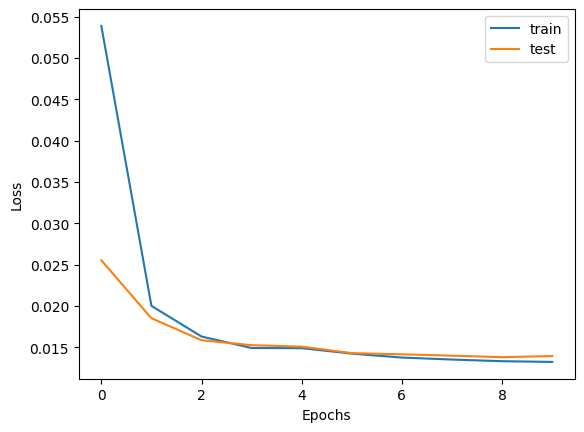

In [ ]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=128, validation_split=0.1,  verbose=1)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


# Evaluate the model
test_loss = model.evaluate(X_test, Y_test, verbose=1)
print("Test Loss:", test_loss)

# Predict the test data
Y_pred = model.predict(X_test)

# Inverse scale the predictions and true values
Y_pred_not_scaled = label_scaler.inverse_transform(Y_pred.reshape(-1, 19)).reshape(Y_pred.shape)
Y_test_not_scaled = label_scaler.inverse_transform(Y_test.reshape(-1, 19)).reshape(Y_test.shape)


# Calculate MSE for each location and step
mse_values = np.zeros((steps_ahead, 19))
for step in range(steps_ahead):
    for location in range(19):
        mse_values[step, location] = mean_squared_error(Y_test_not_scaled[:, step, location], Y_pred_not_scaled[:, step, location])

# Calculate the average MSE across all locations and steps
average_mse = np.mean(mse_values)
print("Average Squared Mean Error:", average_mse, ", not squared:", np.sqrt(average_mse))

r2 = r2_score(Y_test.reshape(-1, 19), Y_pred.reshape(-1, 19))
print("R2 Score:", r2)

model_scores_list.append({"model_name": "multi_output_LSTM", "model_instance": model, "average_mse": average_mse, "r2": r2})

12/12 [==============================] - 2s 187ms/step - loss: 0.0195
Test Loss: 0.019505249336361885
12/12 [==============================] - 4s 225ms/step
Average Squared Mean Error: 4665946.44960666 , not squared: 2160.0801951794892
R2 Score: 0.008870734723523727


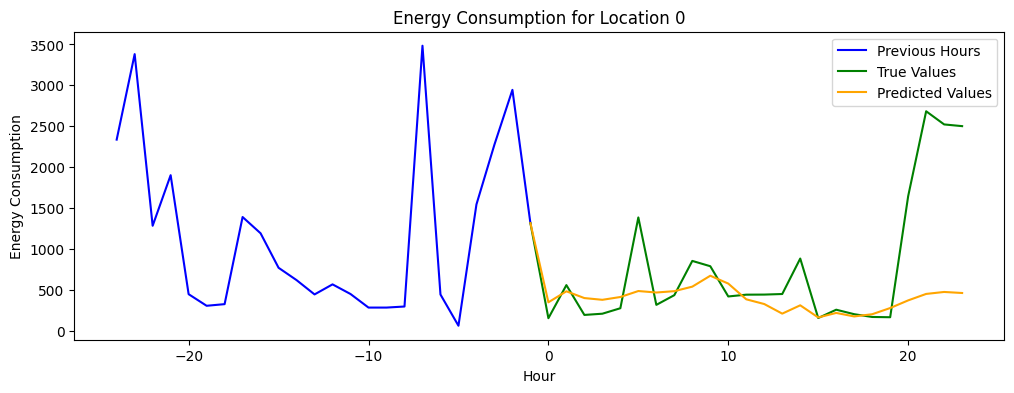

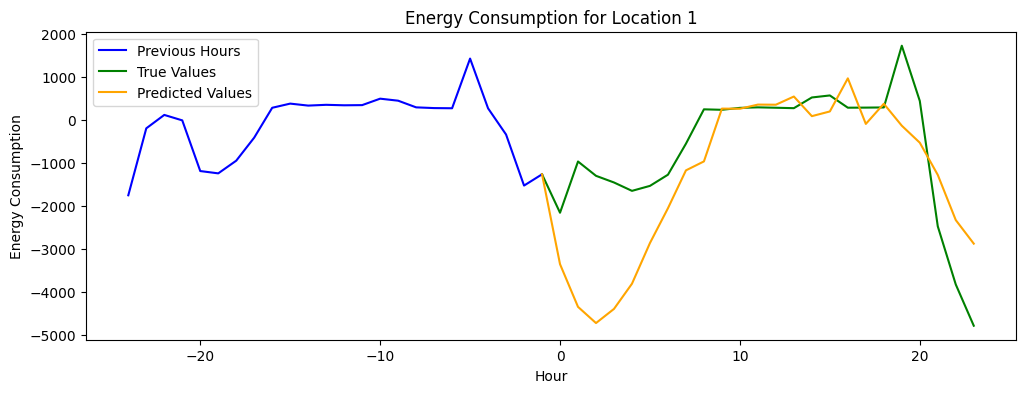

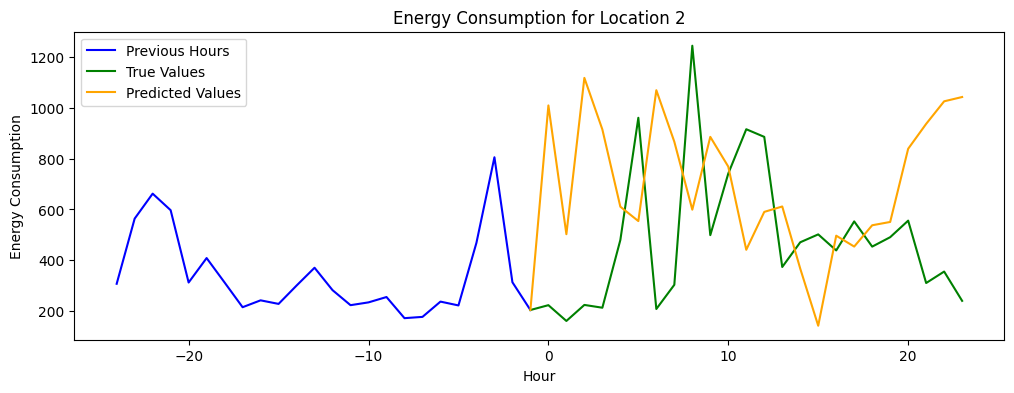

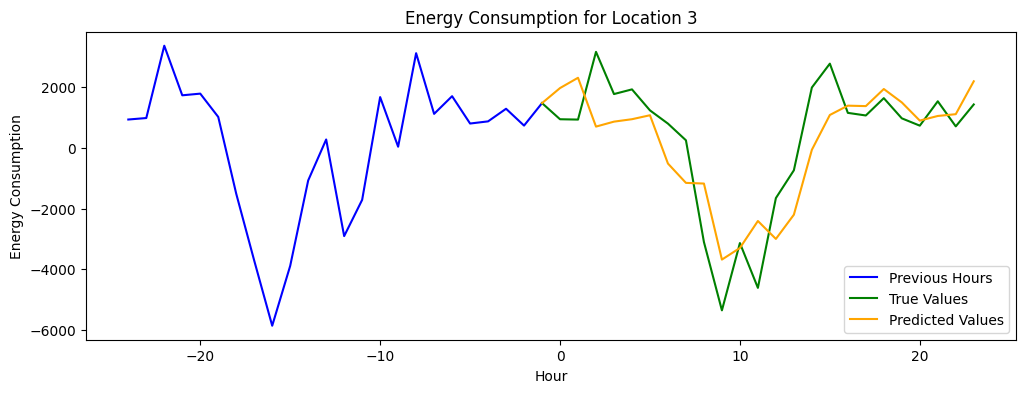

In [ ]:
locations_to_plot = [0, 1, 2, 3]
for location in locations_to_plot:
    plot_location_predictions(X_test,  Y_test_not_scaled, Y_pred_not_scaled, scaler, location, steps_ahead=steps_ahead, n_previous=24)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose


# Separate features and target locations

stl_data = data_with_date.set_index('Date')
features = stl_data.iloc[:, 19:]
locations = stl_data.iloc[:, :19]

num_locations = 1
models = []
mse_scores = []
r2_scores = []

# Split features and target locations into train and test sets

seq_length = 24

for location in range(num_locations):
    print(f"Training model for location {location}")

    # Extract the location data and perform STL decomposition
    location_data = stl_data.iloc[:, location]
    freq = 24
    result = seasonal_decompose(location_data, model='additive')
    trend = result.trend.ffill().bfill()
    seasonal = result.seasonal
    residual = result.resid.ffill().bfill()

    all_data = pd.concat([residual, features], axis=1)

    train_size = int(0.8 * len(all_data))
    data_train, data_test = all_data[:train_size], all_data[train_size:]
    trend_train, trend_test = trend[:train_size], trend[train_size:]
    seasonal_train, seasonal_test = seasonal[:train_size], seasonal[train_size:]
    residual_train, residual_test = residual[:train_size], residual[train_size:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data_train = scaler.fit_transform(data_train)
    scaled_data_test = scaler.transform(data_test)

    # create scaler only for the label
    label_scaler = MinMaxScaler(feature_range=(0, 1))
    label_scaler.fit(data_train.iloc[:, 0].values.reshape(-1, 1))


    # Create input and output sequences for LSTM
    X_train, Y_train = create_overlapping_sequences_single_Y(scaled_data_train, seq_length, steps_ahead=steps_ahead)
    X_test, Y_test = create_overlapping_sequences_single_Y(scaled_data_train, seq_length,steps_ahead=steps_ahead)
    
    
    # Train the LSTM on the residual component
    model = Sequential()
    model.add(LSTM(128*2, input_shape=(seq_length, X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(24))
    model.compile(loss='mse', optimizer='adam')

    history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

    # Evaluate the model
    test_loss = model.evaluate(X_test, Y_test, verbose=1)
    print(f"Test Loss for location {location}:", test_loss)

    # Make predictions on the residual component
    Y_pred = model.predict(X_test)

    # Inverse scale the predictions and true values
    Y_pred_not_scaled = label_scaler.inverse_transform(Y_pred)
    Y_test_not_scaled = label_scaler.inverse_transform(Y_test)

    # adding back seasonality and trend components
    Y_pred_not_scaled = Y_pred_not_scaled + trend_test[:]

    mse = mean_squared_error(Y_test_not_scaled, Y_pred_not_scaled)
    r2 = r2_score(Y_test_not_scaled, Y_pred_not_scaled)

    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"MSE for location {location}:", mse)
    print(f"R2 Score for location {location}:", r2)
    print("\n")

    # Add the seasonal and trend components back to the prediction
    # ... (implement your code for adding the seasonal and trend components)

    # Store the model for future use
    models.append(model)
    

# Calculate mean scores
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)

print("Mean MSE:", average_mse)
print("Mean R2 Score:", average_r2)


Training model for location 0
Epoch 1/10
32/32 [==============================] - 5s 50ms/step - loss: 0.0127 - val_loss: 0.0038
Epoch 2/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0071 - val_loss: 0.0037
Epoch 3/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0067 - val_loss: 0.0036
Epoch 4/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0065 - val_loss: 0.0037
Epoch 5/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0064 - val_loss: 0.0036
Epoch 6/10
32/32 [==============================] - 1s 24ms/step - loss: 0.0063 - val_loss: 0.0035
Epoch 7/10
32/32 [==============================] - 1s 24ms/step - loss: 0.0062 - val_loss: 0.0036
Epoch 8/10
32/32 [==============================] - 1s 23ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 9/10
32/32 [==============================] - 1s 22ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 10/10
35/35 [==============================] - 0s 8ms/step - loss: 0.0053

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose

def create_overlapping_sequences_single_Y(data, seq_length, steps_ahead = 24, overlap = 2, return_start_indices=False):
    X, Y, start_indices = [], [], []
    step_size = seq_length // overlap
    num_sequences = (len(data) - steps_ahead - seq_length) // step_size + 1
    
    for i in range(num_sequences):
        start = i * step_size
        X.append(data[start:start+seq_length])
        Y.append(data[start+seq_length:start+seq_length+steps_ahead, 0]) # considering e_pos_neg_sum_0 to e_pos_neg_sum_19
        start_indices.append(start)
        
    if return_start_indices:
        return np.array(X), np.array(Y), start_indices
    else:
        return np.array(X), np.array(Y)

# Separate features and target locations

stl_data = data_with_date.set_index('Date')
features = stl_data
locations = stl_data.iloc[:, :19]

num_locations = 1
models = []
mse_scores = []
r2_scores = []

# Split features and target locations into train and test sets

seq_length = 24*2

for location in range(num_locations):
    print(f"Training model for location {location}")

    # Extract the location data and perform STL decomposition
    location_data = stl_data.iloc[:, location]
    result = seasonal_decompose(location_data, model='additive')
    trend = result.trend.ffill().bfill()
    seasonal = result.seasonal
    residual = result.resid.ffill().bfill()

    all_data = pd.concat([residual, features], axis=1)

    train_size = int(0.8 * len(all_data))
    data_train, data_test = all_data[:train_size], all_data[train_size:]
    trend_train, trend_test = trend[:train_size], trend[train_size:]
    seasonal_train, seasonal_test = seasonal[:train_size], seasonal[train_size:]
    residual_train, residual_test = residual[:train_size], residual[train_size:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data_train = scaler.fit_transform(data_train)
    scaled_data_test = scaler.transform(data_test)

    # create scaler only for the label
    label_scaler = MinMaxScaler(feature_range=(0, 1))
    label_scaler.fit(data_train.iloc[:, 0].values.reshape(-1, 1))

    # Create input and output sequences for LSTM
    X_train, Y_train = create_overlapping_sequences_single_Y(scaled_data_train, seq_length, steps_ahead=steps_ahead, overlap=20)
    X_test, Y_test, test_start_indices = create_overlapping_sequences_single_Y(scaled_data_train, seq_length, steps_ahead=steps_ahead, return_start_indices=True, overlap=20)

    # Train the LSTM on the residual component
    model = Sequential()
    model.add(LSTM(128*2, input_shape=(seq_length, X_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(24))
    model.compile(loss='mse', optimizer='adam')

    history = model.fit(X_train, Y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

    # Evaluate the model
    test_loss = model.evaluate(X_test, Y_test, verbose=1)
    print(f"Test Loss for location {location}:", test_loss)

    # Make predictions on the residual component
    Y_pred = model.predict(X_test)

    # Inverse scale the predictions and true values
    Y_pred_not_scaled = label_scaler.inverse_transform(Y_pred)
    Y_test_not_scaled = label_scaler.inverse_transform(Y_test)

    reconstructed_predictions = []

    for i, start_index in enumerate(test_start_indices):
        # Get the corresponding seasonal component for the sequence
        seasonal_component = seasonal_test[start_index:start_index + steps_ahead]
        reconstructed_pred = Y_pred_not_scaled[i, :len(seasonal_component)] + seasonal_component.values
        reconstructed_predictions.append(reconstructed_pred)

    reconstructed_predictions = np.array([np.pad(pred, (0, steps_ahead - len(pred))) if len(pred) < steps_ahead else pred for pred in reconstructed_predictions])
    Y_test_not_scaled_trimmed = Y_test_not_scaled[:, :reconstructed_predictions.shape[1]]
    mse = mean_squared_error(Y_test_not_scaled_trimmed, reconstructed_predictions)
    r2 = r2_score(Y_test_not_scaled_trimmed, reconstructed_predictions)


    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"MSE for location {location}:", mse, "not squared:", np.sqrt(mse))
    print(f"R2 Score for location {location}:", r2)
    print("\n")

    # Store the model for future use
    models.append(model)
    

# Calculate mean scores
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)

print("Mean MSE:", average_mse)
print("Mean R2 Score:", average_r2)




Training model for location 0
Epoch 1/10
94/94 [==============================] - 25s 214ms/step - loss: 0.0095 - val_loss: 0.0038
Epoch 2/10
94/94 [==============================] - 23s 248ms/step - loss: 0.0068 - val_loss: 0.0037
Epoch 3/10
94/94 [==============================] - 22s 231ms/step - loss: 0.0066 - val_loss: 0.0037
Epoch 4/10
94/94 [==============================] - 20s 209ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 5/10
94/94 [==============================] - 24s 256ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 6/10
94/94 [==============================] - 27s 285ms/step - loss: 0.0062 - val_loss: 0.0036
Epoch 7/10
94/94 [==============================] - 24s 253ms/step - loss: 0.0061 - val_loss: 0.0035
Epoch 8/10
94/94 [==============================] - 19s 206ms/step - loss: 0.0061 - val_loss: 0.0035
Epoch 9/10
94/94 [==============================] - 22s 235ms/step - loss: 0.0060 - val_loss: 0.0035
Epoch 10/10
208/208 [==============================] - 17s 79

In [ ]:
2382840**0.5

1543.6450369174904

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.utils import AirPassengersDF


train_size = int(0.8 * len(data))

# from data_with_date df keep only columns "epos_0" and "Date"
location_data = data_with_date[["e_pos_neg_sum_0", "Date"]]

# add column only of ones in the location data df 
location_data = pd.concat([location_data, pd.DataFrame(np.ones(len(location_data)))], axis=1)
# change columns names to columns = ["y", "ds", "unique_id"]
location_data.columns = ["y", "ds", "unique_id"]

Y_train_df = pd.DataFrame(location_data[:train_size]) # 132 train
Y_test_df = pd.DataFrame(location_data[train_size:]) # 12 test

# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [NBEATS(input_size=2 * horizon, h=horizon, max_epochs=10),
          NHITS(input_size=2 * horizon, h=horizon, max_epochs=10)]

nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_train_df)


# Neural Forecast


In [174]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
from neuralforecast.losses.pytorch import MQLoss

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS
from neuralforecast.utils import AirPassengersDF
from neuralforecast.models import LSTM, DilatedRNN, NHITS

train_size = int(0.8 * len(data))
# from data_with_date df keep only columns "epos_0" and "Date"
location_data = data_with_date[["e_pos_neg_sum_0", "Date"]]

# add column only of ones in the location data df 
location_data = pd.concat([location_data, pd.DataFrame(np.ones(len(location_data)))], axis=1)
# change columns names to columns = ["y", "ds", "unique_id"]
location_data.columns = ["y", "ds", "unique_id"]
location_data_tr = location_data[:train_size]
location_data_te = location_data[train_size:]
horizon = 48
levels = [80, 90]
models = [LSTM(input_size=-1, h=horizon, max_epochs=15),
          NHITS(input_size=7*horizon, h=horizon, max_epochs=15,
                n_freq_downsample=[24, 12, 1])]

fcst = NeuralForecast(models=models, freq='H')
fcst.fit(df=location_data_tr)
Y_hat_df = fcst.predict().reset_index()


Global seed set to 1
Global seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.41it/s]


In [175]:
Y_hat_df = fcst.predict().reset_index()
Y_hat_df

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.38it/s]


unique_id                        ds        LSTM       NHITS
0         1.0 2022-07-12 13:00:00+00:00  149.584335  349.376648
1         1.0 2022-07-12 14:00:00+00:00  158.930237  360.684448
2         1.0 2022-07-12 15:00:00+00:00  185.868469  364.932434
3         1.0 2022-07-12 16:00:00+00:00  167.346313  401.531342
4         1.0 2022-07-12 17:00:00+00:00  166.475250  393.781494
5         1.0 2022-07-12 18:00:00+00:00  161.217499  381.136627
6         1.0 2022-07-12 19:00:00+00:00  147.163498  411.134369
7         1.0 2022-07-12 20:00:00+00:00  164.216965  398.839264
8         1.0 2022-07-12 21:00:00+00:00  142.721878  393.112640
9         1.0 2022-07-12 22:00:00+00:00  145.757980  374.854553
10        1.0 2022-07-12 23:00:00+00:00  164.926605  363.471924
11        1.0 2022-07-13 00:00:00+00:00  158.369965  354.328613
12        1.0 2022-07-13 01:00:00+00:00  149.512100  349.648834
13        1.0 2022-07-13 02:00:00+00:00  165.188690  332.654144
14        1.0 2022-07-13 03:00:00+00:00  171.978790  340.093140
15        1.0 2022-07-13 04:00:00+00:00  153.762238  338.124542
16        1.0 2022-07-13 05:00:00+00:00  152.051620  332.065094
17        1.0 2022-07-13 06:00:00+00:00  147.835159  359.544250
18        1.0 2022-07-13 07:00:00+00:00  126.859756  369.394104
19        1.0 2022-07-13 08:00:00+00:00  142.350464  368.250763
20        1.0 2022-07-13 09:00:00+00:00  154.008881  368.324310
21        1.0 2022-07-13 10:00:00+00:00  155.544891  356.556641
22        1.0 2022-07-13 11:00:00+00:00  155.509811  343.514771
23        1.0 2022-07-13 12:00:00+00:00  161.043579  341.641449
24        1.0 2022-07-13 13:00:00+00:00  152.944366  352.153259
25        1.0 2022-07-13 14:00:00+00:00  181.751404  334.117767
26        1.0 2022-07-13 15:00:00+00:00  180.591370  358.667633
27        1.0 2022-07-13 16:00:00+00:00  174.738434  358.339264
28        1.0 2022-07-13 17:00:00+00:00  205.529480  366.895325
29        1.0 2022-07-13 18:00:00+00:00  173.875397  373.169006
30        1.0 2022-07-13 19:00:00+00:00  181.753326  374.944824
31        1.0 2022-07-13 20:00:00+00:00  176.384293  361.895569
32        1.0 2022-07-13 21:00:00+00:00  157.328049  362.324524
33        1.0 2022-07-13 22:00:00+00:00  162.629547  346.561646
34        1.0 2022-07-13 23:00:00+00:00  168.757645  340.956238
35        1.0 2022-07-14 00:00:00+00:00  171.998077  311.644409
36        1.0 2022-07-14 01:00:00+00:00  150.273743  312.603027
37        1.0 2022-07-14 02:00:00+00:00  173.367661  316.017548
38        1.0 2022-07-14 03:00:00+00:00  170.894653  312.305756
39        1.0 2022-07-14 04:00:00+00:00  163.415009  312.082367
40        1.0 2022-07-14 05:00:00+00:00  165.154785  328.792603
41        1.0 2022-07-14 06:00:00+00:00  152.596252  344.999664
42        1.0 2022-07-14 07:00:00+00:00  150.828064  327.149506
43        1.0 2022-07-14 08:00:00+00:00  152.751129  352.248291
44        1.0 2022-07-14 09:00:00+00:00  152.092743  357.222961
45        1.0 2022-07-14 10:00:00+00:00  138.980591  339.444885
46        1.0 2022-07-14 11:00:00+00:00  155.820541  338.983154
47        1.0 2022-07-14 12:00:00+00:00  164.861176  340.340668

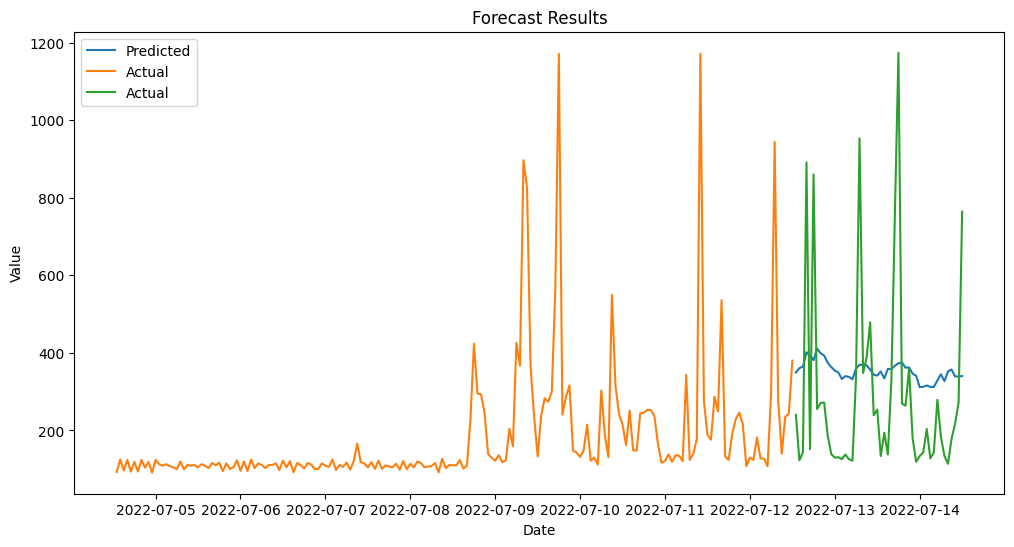

In [176]:
plt.figure(figsize=(12,6))
plt.plot(location_data_te["ds"][:horizon], Y_hat_df["NHITS"], label="Predicted")

plt.plot(location_data_tr["ds"][-4*horizon:], location_data_tr["y"][-4*horizon:], label="Actual")
plt.plot(location_data_te["ds"][:horizon], location_data_te["y"][:horizon], label="Actual")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Forecast Results")
plt.legend()
plt.show()

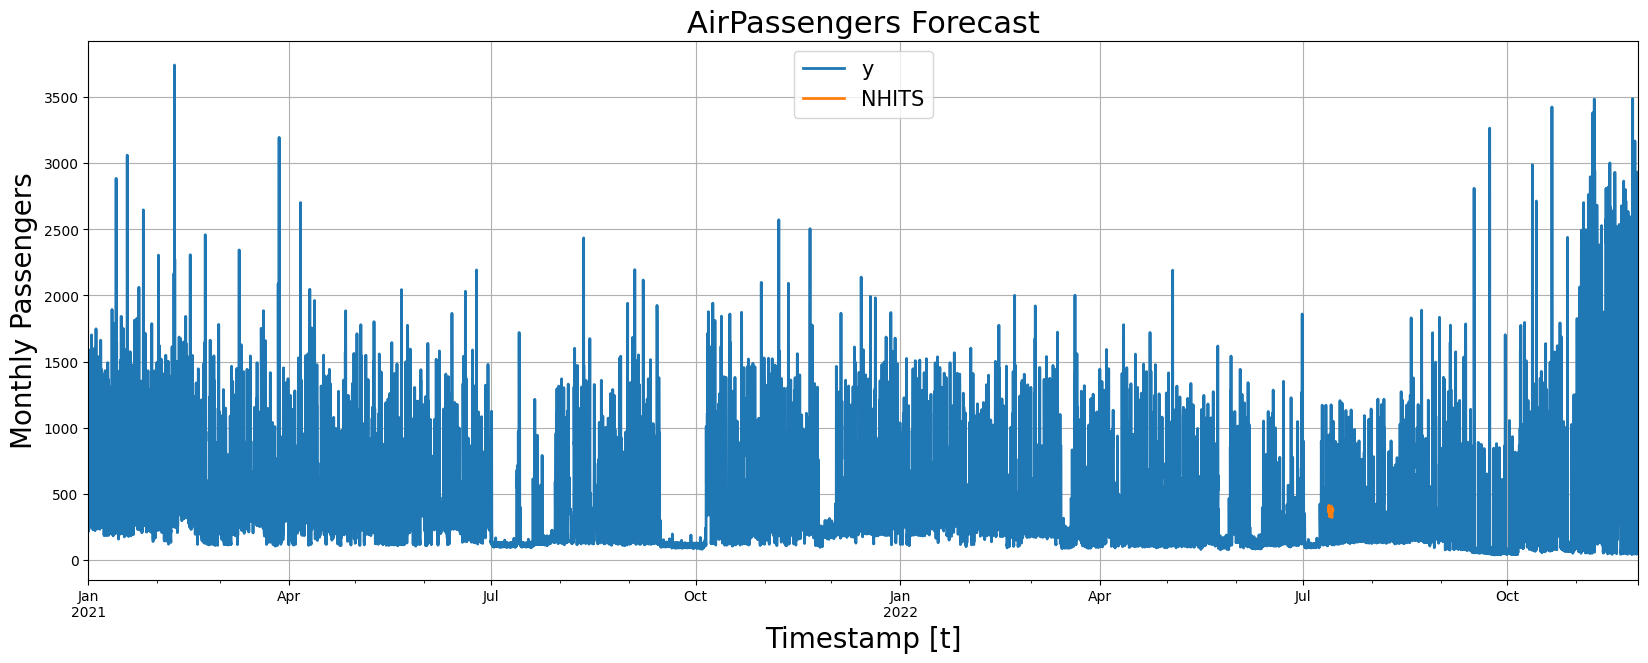

In [137]:

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y','NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [127]:
Y_hat_df

y                        ds  unique_id  NHITS
0      240.0 2022-07-12 13:00:00+00:00        1.0    NaN
1      123.0 2022-07-12 14:00:00+00:00        1.0    NaN
2      144.0 2022-07-12 15:00:00+00:00        1.0    NaN
3      891.0 2022-07-12 16:00:00+00:00        1.0    NaN
4      152.0 2022-07-12 17:00:00+00:00        1.0    NaN
...      ...                       ...        ...    ...
3341   262.0 2022-11-28 18:00:00+00:00        1.0    NaN
3342  1037.0 2022-11-28 19:00:00+00:00        1.0    NaN
3343   948.0 2022-11-28 20:00:00+00:00        1.0    NaN
3344   215.0 2022-11-28 21:00:00+00:00        1.0    NaN
3345   240.0 2022-11-28 22:00:00+00:00        1.0    NaN

[3346 rows x 4 columns]

In [113]:
Y_hat_df

y                        ds  unique_id  NHITS
0      240.0 2022-07-12 13:00:00+00:00        1.0    NaN
1      123.0 2022-07-12 14:00:00+00:00        1.0    NaN
2      144.0 2022-07-12 15:00:00+00:00        1.0    NaN
3      891.0 2022-07-12 16:00:00+00:00        1.0    NaN
4      152.0 2022-07-12 17:00:00+00:00        1.0    NaN
...      ...                       ...        ...    ...
3341   262.0 2022-11-28 18:00:00+00:00        1.0    NaN
3342  1037.0 2022-11-28 19:00:00+00:00        1.0    NaN
3343   948.0 2022-11-28 20:00:00+00:00        1.0    NaN
3344   215.0 2022-11-28 21:00:00+00:00        1.0    NaN
3345   240.0 2022-11-28 22:00:00+00:00        1.0    NaN

[3346 rows x 4 columns]

In [94]:
data_with_date

e_pos_neg_sum_0  e_pos_neg_sum_1  e_pos_neg_sum_2  e_pos_neg_sum_3   
0                485.0            810.0           1862.0           2469.0  \
1                218.0           1433.0           1679.0           2330.0   
2                224.0           2046.0           1749.0           2457.0   
3                287.0           1688.0           1879.0           2123.0   
4                227.0           1762.0           1998.0           4850.0   
...                ...              ...              ...              ...   
16722            262.0           2515.0           2251.0           2948.0   
16723           1037.0           2458.0           1263.0           3406.0   
16724            948.0            637.0           1235.0           2146.0   
16725            215.0            464.0           1191.0           1159.0   
16726            240.0            778.0           1054.0           1243.0   

       e_pos_neg_sum_4  e_pos_neg_sum_5  e_pos_neg_sum_6  e_pos_neg_sum_7   
0          1445.581219           1457.0           3311.0            794.0  \
1          1317.436378           3292.0           3039.0            659.0   
2          1185.000000           1029.0           1919.0            477.0   
3           558.000000            425.0           2592.0            410.0   
4           522.000000           2439.0           3351.0            402.0   
...                ...              ...              ...              ...   
16722      1903.000000           3052.0           1570.0           1019.0   
16723      1518.000000           4415.0           1618.0           1057.0   
16724      1800.000000           2901.0           1812.0           1043.0   
16725      1059.000000           3217.0           1350.0            809.0   
16726       497.000000           5229.0            323.0            487.0   

       e_pos_neg_sum_8  e_pos_neg_sum_9  ...  month_4  month_5  month_6   
0                559.0            847.0  ...    False    False    False  \
1                634.0           1574.0  ...    False    False    False   
2                685.0            828.0  ...    False    False    False   
3                288.0            341.0  ...    False    False    False   
4                317.0            307.0  ...    False    False    False   
...                ...              ...  ...      ...      ...      ...   
16722           1324.0            549.0  ...    False    False    False   
16723            536.0            434.0  ...    False    False    False   
16724            499.0            371.0  ...    False    False    False   
16725            357.0            369.0  ...    False    False    False   
16726            306.0            351.0  ...    False    False    False   

       month_7  month_8  month_9  month_10  month_11  month_12 hour  
0        False    False    False     False     False     False    0  
1        False    False    False     False     False     False    1  
2        False    False    False     False     False     False    2  
3        False    False    False     False     False     False    3  
4        False    False    False     False     False     False    4  
...        ...      ...      ...       ...       ...       ...  ...  
16722    False    False    False     False      True     False   18  
16723    False    False    False     False      True     False   19  
16724    False    False    False     False      True     False   20  
16725    False    False    False     False      True     False   21  
16726    False    False    False     False      True     False   22  

[16727 rows x 118 columns]

In [89]:
from neuralforecast.utils import AirPassengersDF
# get unique values from column unique_id
AirPassengersDF['unique_id'].unique()

array([1.])

In [92]:
AirPassengersDF

unique_id         ds      y
0          1.0 1949-01-31  112.0
1          1.0 1949-02-28  118.0
2          1.0 1949-03-31  132.0
3          1.0 1949-04-30  129.0
4          1.0 1949-05-31  121.0
..         ...        ...    ...
139        1.0 1960-08-31  606.0
140        1.0 1960-09-30  508.0
141        1.0 1960-10-31  461.0
142        1.0 1960-11-30  390.0
143        1.0 1960-12-31  432.0

[144 rows x 3 columns]

In [91]:
# count nan in array
location_data

e_pos_neg_sum_0    0
0                485.0  1.0
1                218.0  1.0
2                224.0  1.0
3                287.0  1.0
4                227.0  1.0
...                ...  ...
16722            262.0  1.0
16723           1037.0  1.0
16724            948.0  1.0
16725            215.0  1.0
16726            240.0  1.0

[16727 rows x 2 columns]

In [ ]:
result = seasonal_decompose(location_data, model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid

In [ ]:
residual

Date
2021-01-01 00:00:00+00:00           NaN
2021-01-01 01:00:00+00:00           NaN
2021-01-01 02:00:00+00:00           NaN
2021-01-01 03:00:00+00:00           NaN
2021-01-01 04:00:00+00:00           NaN
                                ...    
2022-11-28 18:00:00+00:00    952.144306
2022-11-28 19:00:00+00:00    952.144306
2022-11-28 20:00:00+00:00    952.144306
2022-11-28 21:00:00+00:00    952.144306
2022-11-28 22:00:00+00:00    952.144306
Name: resid, Length: 16727, dtype: float64

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape



# Create the CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=12, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(19 * steps_ahead),
    Reshape((steps_ahead, 19))
])

model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)



Epoch 1/10
12/12 [==============================] - 2s 121ms/step - loss: 0.1824 - val_loss: 0.0973
Epoch 2/10
12/12 [==============================] - 1s 103ms/step - loss: 0.0311 - val_loss: 0.0178
Epoch 3/10
12/12 [==============================] - 1s 116ms/step - loss: 0.0138 - val_loss: 0.0122
Epoch 4/10
12/12 [==============================] - 1s 102ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 5/10
12/12 [==============================] - 1s 101ms/step - loss: 0.0099 - val_loss: 0.0108
Epoch 6/10
12/12 [==============================] - 1s 107ms/step - loss: 0.0090 - val_loss: 0.0111
Epoch 7/10
12/12 [==============================] - 1s 107ms/step - loss: 0.0085 - val_loss: 0.0098
Epoch 8/10
12/12 [==============================] - 1s 115ms/step - loss: 0.0082 - val_loss: 0.0117
Epoch 9/10
12/12 [==============================] - 1s 118ms/step - loss: 0.0085 - val_loss: 0.0128
Epoch 10/10
12/12 [==============================] - 1s 118ms/step - loss: 0.0083 - val_loss: 0.0121

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


# Evaluate the model
test_loss = model.evaluate(X_test, Y_test, verbose=1)
print("Test Loss:", test_loss)

# Predict the test data
Y_pred = model.predict(X_test)

# Inverse scale the predictions and true values
Y_pred_not_scaled = label_scaler.inverse_transform(Y_pred.reshape(-1, 19)).reshape(Y_pred.shape)
Y_test_not_scaled = label_scaler.inverse_transform(Y_test.reshape(-1, 19)).reshape(Y_test.shape)


# Calculate MSE for each location and step
mse_values = np.zeros((steps_ahead, 19))
for step in range(steps_ahead):
    for location in range(19):
        mse_values[step, location] = mean_squared_error(Y_test_not_scaled[:, step, location], Y_pred_not_scaled[:, step, location])

# Calculate the average MSE across all locations and steps
average_mse = np.mean(mse_values)
print("Average Squared Mean Error:", average_mse, ", not squared:", np.sqrt(average_mse))

r2 = r2_score(Y_test.reshape(-1, 19), Y_pred.reshape(-1, 19))
print("R2 Score:", r2)

model_scores_list.append({"model_name": "multi_output_convolutional", "model_instance": model, "average_mse": average_mse, "r2": r2})

3/3 [==============================] - 0s 16ms/step - loss: 0.0224
Test Loss: 0.02235102839767933
3/3 [==============================] - 0s 14ms/step
Average Squared Mean Error: 5346260.111023485 , not squared: 2312.1981124080794
R2 Score: -0.20923290855127025


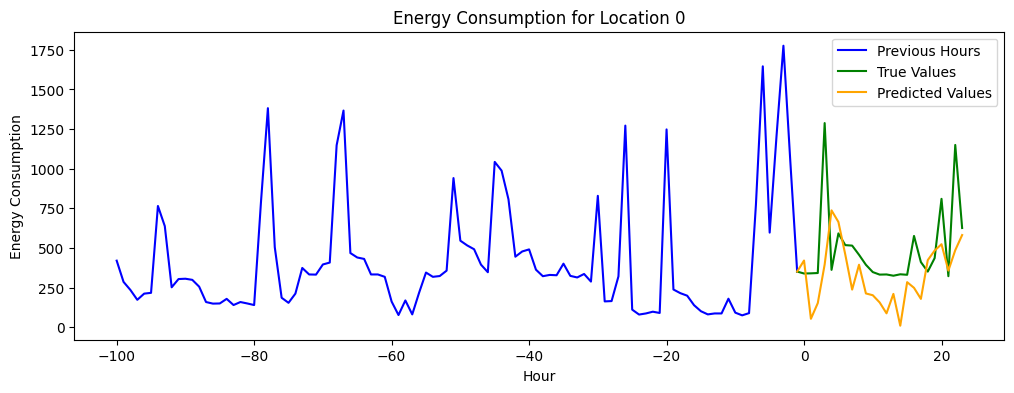

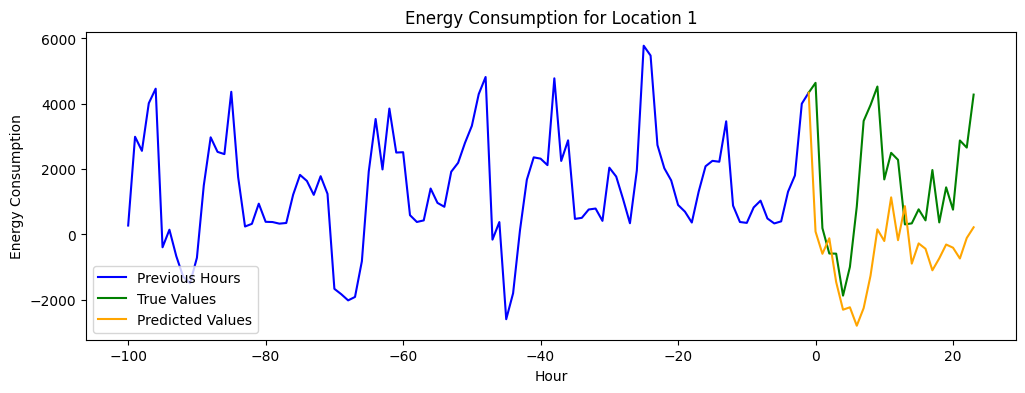

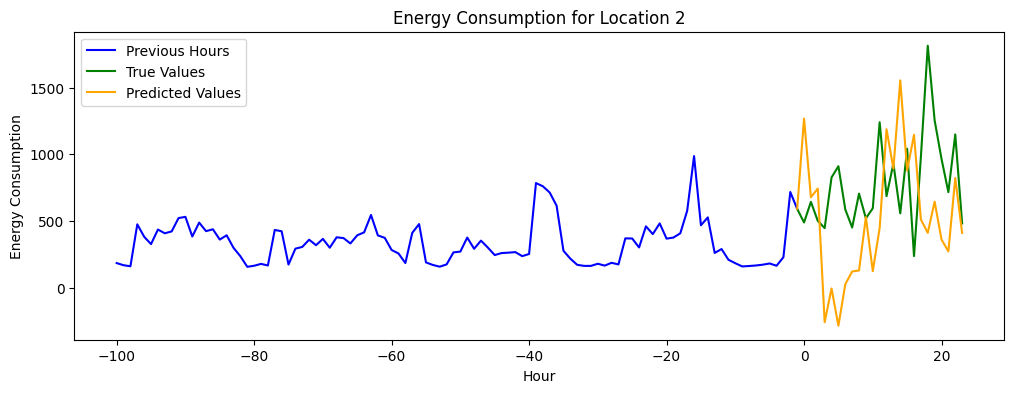

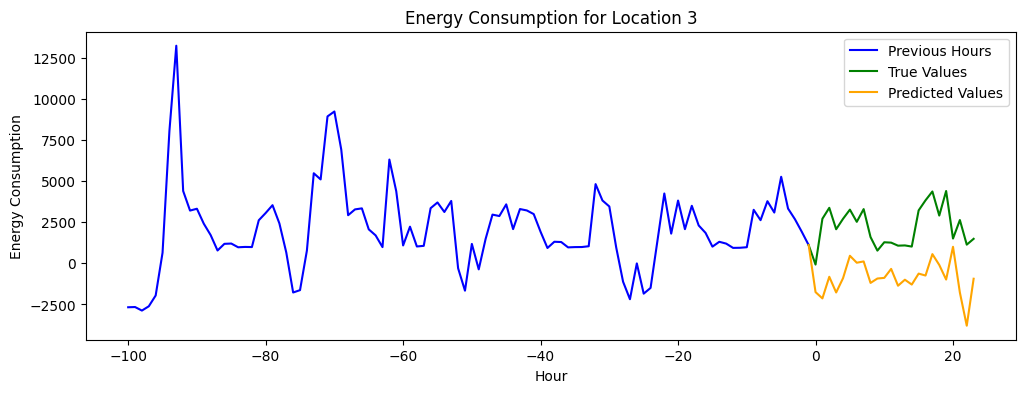

In [ ]:
locations_to_plot = [0, 1, 2, 3]
for location in locations_to_plot:
    plot_location_predictions(X_test,  Y_test_not_scaled, Y_pred_not_scaled, scaler, location, steps_ahead=steps_ahead)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Reshape, Input, Concatenate



# First level of the hierarchical model
input_layer = Input(shape=(seq_length, X_train.shape[2]))
shared_conv = Conv1D(filters=64, kernel_size=6, activation='relu')(input_layer)
shared_flatten = Flatten()(shared_conv)

# Second level of the hierarchical model
location_models = []
for i in range(19):
    loc_conv = Conv1D(filters=32, kernel_size=3, activation='relu')(shared_conv)
    loc_flatten = Flatten()(loc_conv)
    loc_dense = Dense(steps_ahead)(loc_flatten)
    location_models.append(loc_dense)

# Combine the location-specific predictions
combined = Concatenate(axis=-1)(location_models)
output_layer = Reshape((steps_ahead, 19))(combined)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_split=0.1, verbose=1)





Epoch 1/15
12/12 [==============================] - 7s 256ms/step - loss: 0.3579 - val_loss: 0.0202
Epoch 2/15
12/12 [==============================] - 3s 233ms/step - loss: 0.0209 - val_loss: 0.0156
Epoch 3/15
12/12 [==============================] - 3s 241ms/step - loss: 0.0146 - val_loss: 0.0154
Epoch 4/15
12/12 [==============================] - 3s 243ms/step - loss: 0.0128 - val_loss: 0.0129
Epoch 5/15
12/12 [==============================] - 3s 243ms/step - loss: 0.0119 - val_loss: 0.0124
Epoch 6/15
12/12 [==============================] - 3s 245ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 7/15
12/12 [==============================] - 3s 243ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 8/15
12/12 [==============================] - 3s 250ms/step - loss: 0.0103 - val_loss: 0.0107
Epoch 9/15
12/12 [==============================] - 3s 276ms/step - loss: 0.0100 - val_loss: 0.0101
Epoch 10/15
12/12 [==============================] - 3s 263ms/step - loss: 0.0094 - val_loss: 0.0098

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score



# Evaluate the model
test_loss = model.evaluate(X_test, Y_test, verbose=1)
print("Test Loss:", test_loss)

# Predict the test data
Y_pred = model.predict(X_test)

# Inverse scale the predictions and true values
Y_pred_not_scaled = label_scaler.inverse_transform(Y_pred.reshape(-1, 19)).reshape(Y_pred.shape)
Y_test_not_scaled = label_scaler.inverse_transform(Y_test.reshape(-1, 19)).reshape(Y_test.shape)


# Calculate MSE for each location and step
mse_values = np.zeros((steps_ahead, 19))
for step in range(steps_ahead):
    for location in range(19):
        mse_values[step, location] = mean_squared_error(Y_test_not_scaled[:, step, location], Y_pred_not_scaled[:, step, location])

# Calculate the average MSE across all locations and steps
average_mse = np.mean(mse_values)
print("Average Squared Mean Error:", average_mse, ", not squared:", np.sqrt(average_mse))

r2 = r2_score(Y_test.reshape(-1, 19), Y_pred.reshape(-1, 19))
print("R2 Score:", r2)

model_scores_list.append({"model_name": "hierarchical_convolutional", "model_instance": model, "average_mse": average_mse, "r2": r2})

3/3 [==============================] - 0s 33ms/step - loss: 0.0214
Test Loss: 0.0214296393096447
3/3 [==============================] - 1s 36ms/step
Average Squared Mean Error: 6184816.814011749 , not squared: 2486.929193606394
R2 Score: -0.10283293410882906


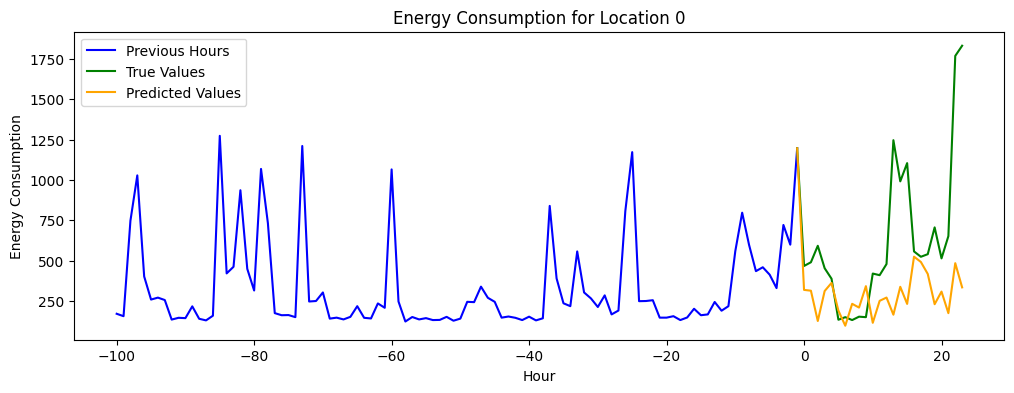

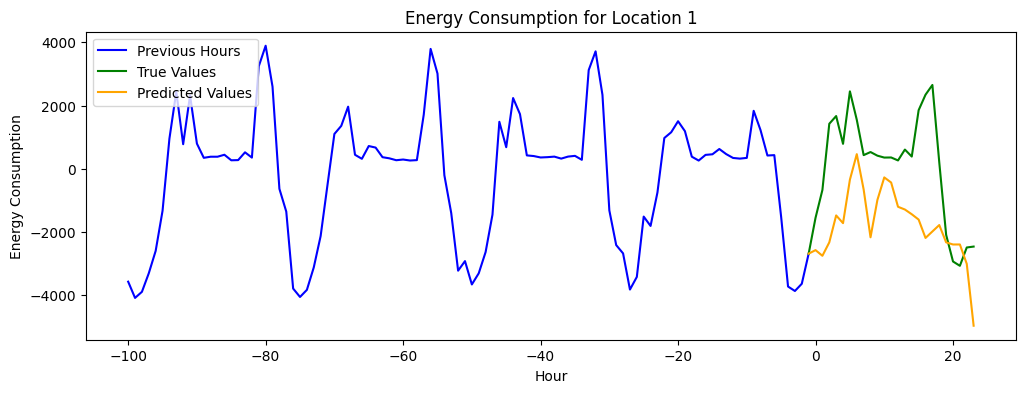

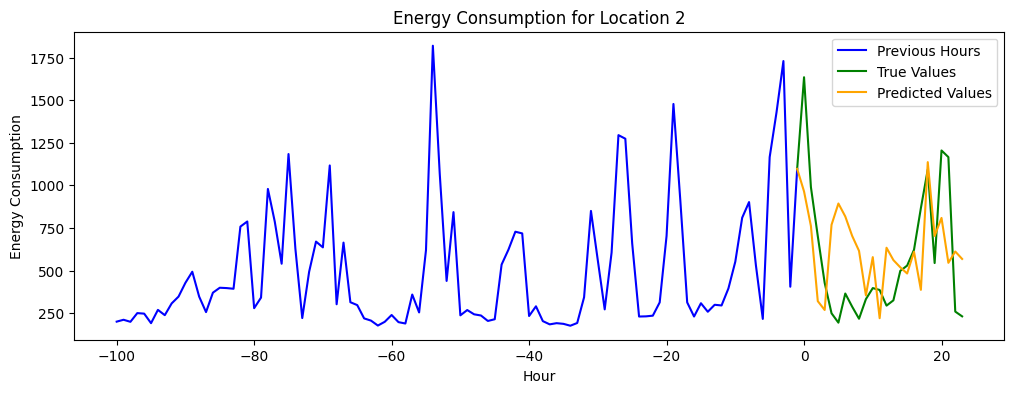

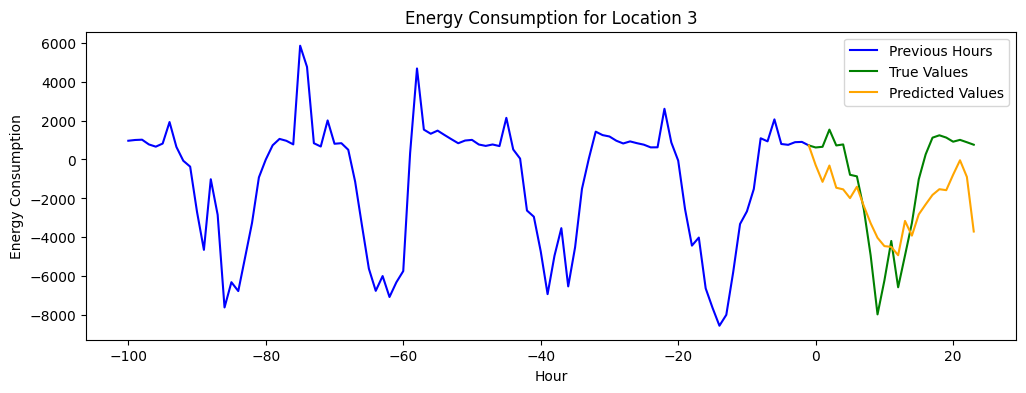

In [ ]:
locations_to_plot = [0, 1, 2, 3]
for location in locations_to_plot:
    plot_location_predictions(X_test,  Y_test_not_scaled, Y_pred_not_scaled, scaler, location, steps_ahead=steps_ahead)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


steps_ahead = 24
num_locations = 19
mse_scores = []
r2_scores = []
models = []

for location in range(num_locations):
    print(f"Training model for location {location}")

    # Create the LSTM model
    model = Sequential()
    model.add(LSTM(128*2, input_shape=(seq_length, data.shape[1]), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(steps_ahead))
    model.compile(loss='mse', optimizer='adam')

    # Train the model
    history = model.fit(X_train, Y_train[:, :, location], epochs=6, batch_size=32, validation_split=0.1, verbose=1)
    models.append(model)

    # Evaluate the model
    test_loss = model.evaluate(X_test, Y_test[:, :, location], verbose=1)
    print(f"Test Loss for location {location}:", test_loss)

    # Predict the test data
    Y_pred = model.predict(X_test)

    # Inverse scale the predictions and true values
    column_scale = label_scaler.scale_[location]
    column_min = label_scaler.min_[location]
    Y_pred_not_scaled = (Y_pred - column_min) / column_scale
    Y_test_not_scaled = (Y_test[:, :, location] - column_min) / column_scale


    # Calculate the MSE and R2 score
    mse = mean_squared_error(Y_test_not_scaled, Y_pred_not_scaled)
    r2 = r2_score(Y_test_not_scaled, Y_pred_not_scaled)

    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"MSE for location {location}:", mse)
    print(f"R2 Score for location {location}:", r2)
    print("\n")

# Calculate mean scores
average_mse = np.mean(mse_scores)
r2 = np.mean(r2_scores)

print("Mean MSE:", average_mse)
print("Mean R2 Score:", r2)

model_scores_list.append({"model_name": "multiple_LSTMs", "model_instance": models, "average_mse": average_mse, "r2": r2})


Training model for location 0
Epoch 1/6
12/12 [==============================] - 39s 3s/step - loss: 0.0190 - val_loss: 0.0059
Epoch 2/6
12/12 [==============================] - 34s 3s/step - loss: 0.0085 - val_loss: 0.0052
Epoch 3/6
12/12 [==============================] - 37s 3s/step - loss: 0.0075 - val_loss: 0.0041
Epoch 4/6
12/12 [==============================] - 40s 3s/step - loss: 0.0071 - val_loss: 0.0046
Epoch 5/6
12/12 [==============================] - 43s 4s/step - loss: 0.0069 - val_loss: 0.0044
Epoch 6/6
3/3 [==============================] - 2s 805ms/step - loss: 0.0235
Test Loss for location 0: 0.023540759459137917
3/3 [==============================] - 3s 749ms/step
MSE for location 0: 316204.7927051093
R2 Score for location 0: 0.0033594702815908976


Training model for location 1
Epoch 1/6
12/12 [==============================] - 48s 4s/step - loss: 0.0811 - val_loss: 0.0438
Epoch 2/6
12/12 [==============================] - 47s 4s/step - loss: 0.0301 - val_loss: 0.0

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Concatenate, Conv1D

def create_tcn_block(input_layer, num_filters, kernel_size, dilation_rate, activation='relu'):
    tcn = Conv1D(filters=num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal', activation=activation)(input_layer)
    return tcn

# First level of the hierarchical model
input_layer = Input(shape=(seq_length, X_train.shape[2]))
shared_tcn = create_tcn_block(input_layer, num_filters=64, kernel_size=24, dilation_rate=1)
shared_flatten = Flatten()(shared_tcn)

# Second level of the hierarchical model
location_models = []
for i in range(19):
    loc_tcn = create_tcn_block(shared_tcn, num_filters=32, kernel_size=12, dilation_rate=1)
    loc_flatten = Flatten()(loc_tcn)
    loc_dense = Dense(steps_ahead)(loc_flatten)
    location_models.append(loc_dense)

# Combine the location-specific predictions
combined = Concatenate(axis=-1)(location_models)
output_layer = Reshape((steps_ahead, 19))(combined)

# Create and compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mse', optimizer='adam')

# Train the model
history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/15
12/12 [==============================] - 19s 1s/step - loss: 0.2257 - val_loss: 0.0155
Epoch 2/15
12/12 [==============================] - 14s 1s/step - loss: 0.0190 - val_loss: 0.0137
Epoch 3/15
12/12 [==============================] - 14s 1s/step - loss: 0.0133 - val_loss: 0.0122
Epoch 4/15
12/12 [==============================] - 15s 1s/step - loss: 0.0116 - val_loss: 0.0110
Epoch 5/15
12/12 [==============================] - 15s 1s/step - loss: 0.0106 - val_loss: 0.0099
Epoch 6/15
12/12 [==============================] - 15s 1s/step - loss: 0.0101 - val_loss: 0.0094
Epoch 7/15
12/12 [==============================] - 15s 1s/step - loss: 0.0096 - val_loss: 0.0093
Epoch 8/15
12/12 [==============================] - 15s 1s/step - loss: 0.0091 - val_loss: 0.0091
Epoch 9/15
12/12 [==============================] - 15s 1s/step - loss: 0.0088 - val_loss: 0.0092
Epoch 10/15
12/12 [==============================] - 15s 1s/step - loss: 0.0087 - val_loss: 0.0090
Epoch 11/15
12/12 [

In [ ]:
# Evaluate the model
test_loss = model.evaluate(X_test, Y_test, verbose=1)
print("Test Loss:", test_loss)

# Predict the test data
Y_pred = model.predict(X_test)

# Inverse scale the predictions and true values
Y_pred_not_scaled = label_scaler.inverse_transform(Y_pred.reshape(-1, 19)).reshape(Y_pred.shape)
Y_test_not_scaled = label_scaler.inverse_transform(Y_test.reshape(-1, 19)).reshape(Y_test.shape)


# Calculate MSE for each location and step
mse_values = np.zeros((steps_ahead, 19))
for step in range(steps_ahead):
    for location in range(19):
        mse_values[step, location] = mean_squared_error(Y_test_not_scaled[:, step, location], Y_pred_not_scaled[:, step, location])

# Calculate the average MSE across all locations and steps
average_mse = np.mean(mse_values)
print("Average Squared Mean Error:", average_mse, ", not squared:", np.sqrt(average_mse))

r2 = r2_score(Y_test.reshape(-1, 19), Y_pred.reshape(-1, 19))
print("R2 Score:", r2)

model_scores_list.append({"model_name": "hierarchical_temporal_convolutional", "model_instance": model, "average_mse": average_mse, "r2": r2})

3/3 [==============================] - 1s 393ms/step - loss: 0.0193
Test Loss: 0.01929011009633541
3/3 [==============================] - 2s 392ms/step
Average Squared Mean Error: 4820334.755909012 , not squared: 2195.5260772555202
R2 Score: 0.04378049360388517


c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


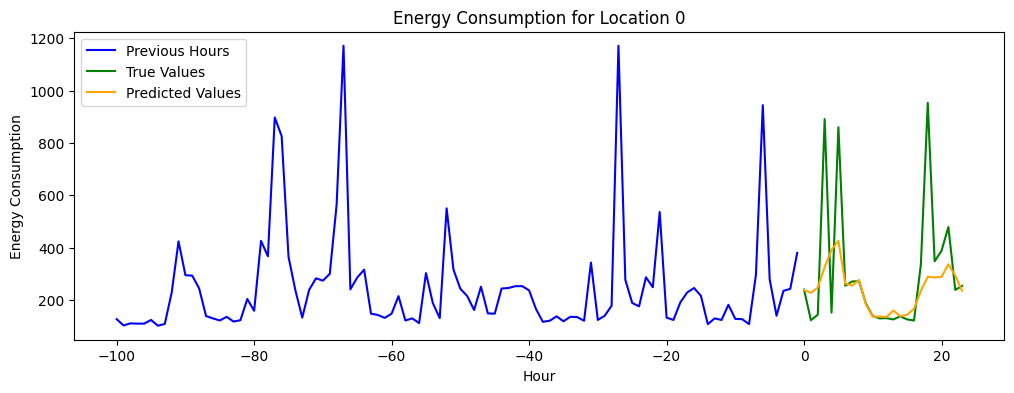

c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


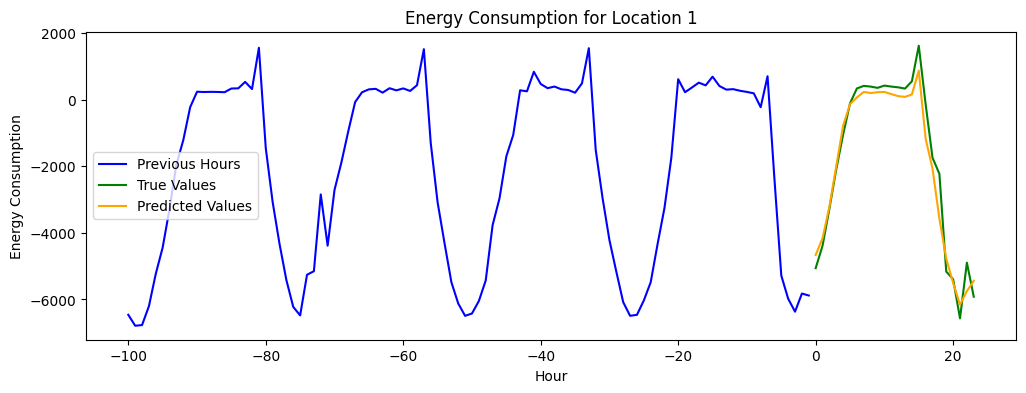

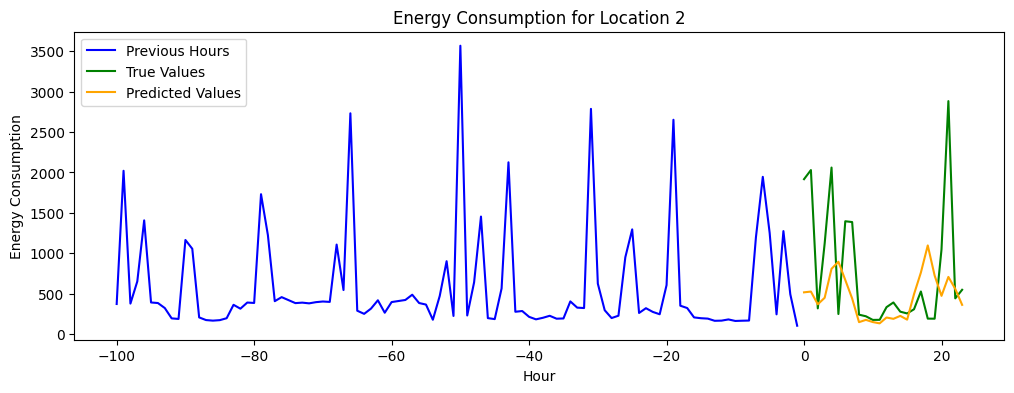

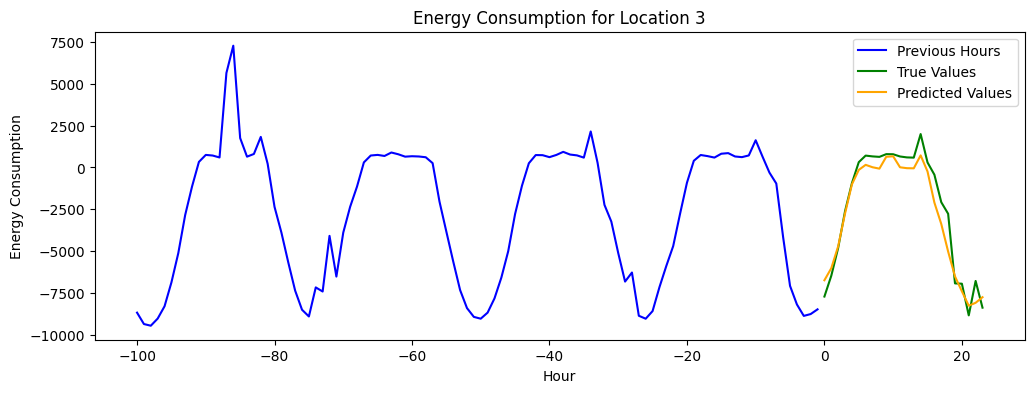

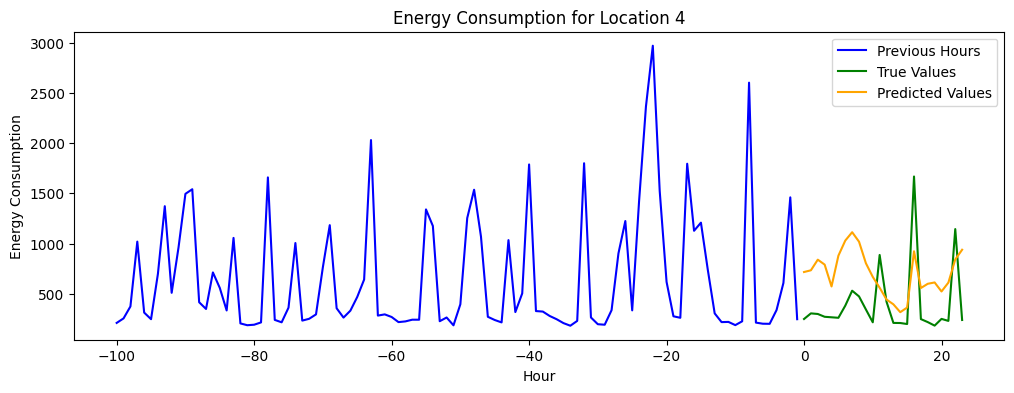

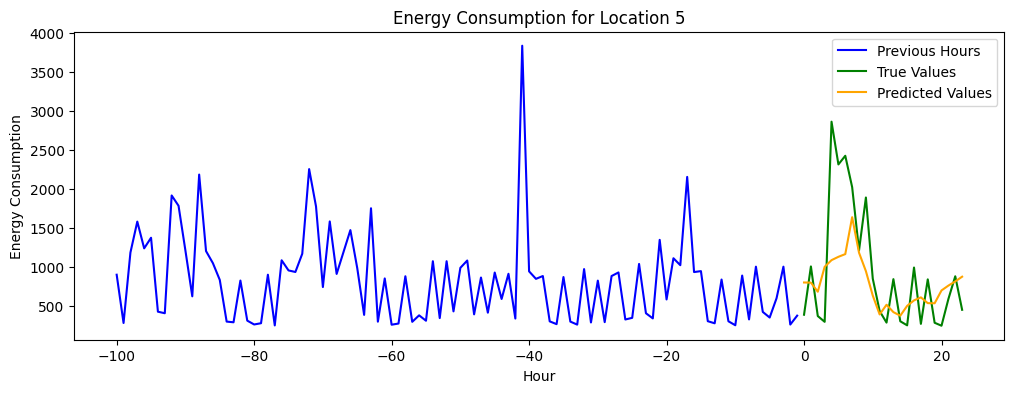

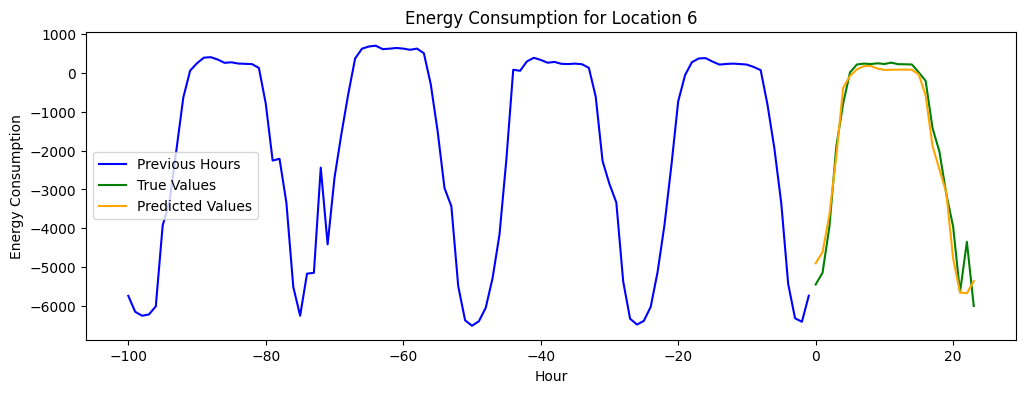

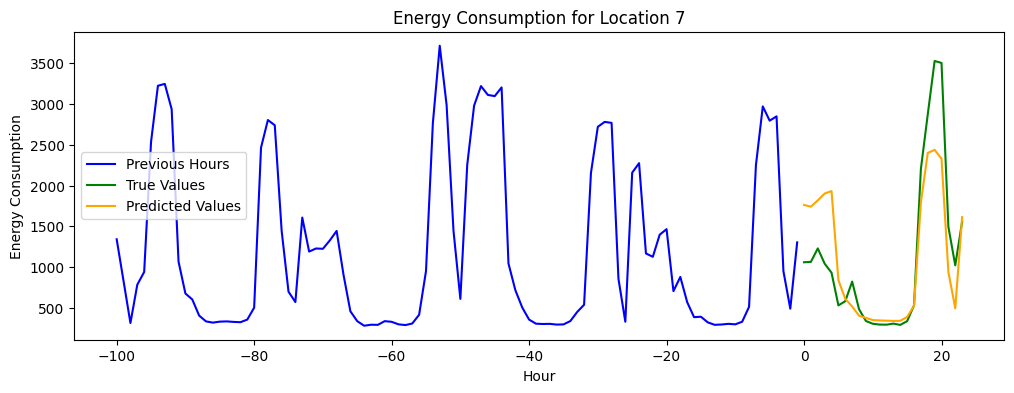

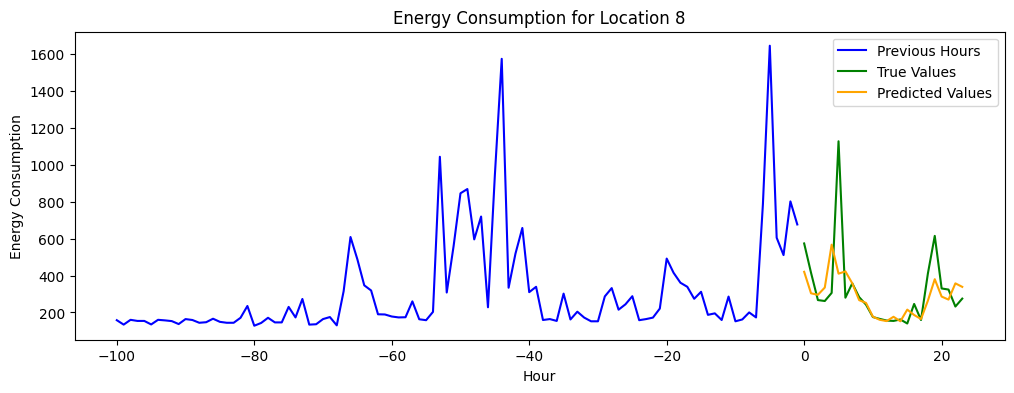

c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


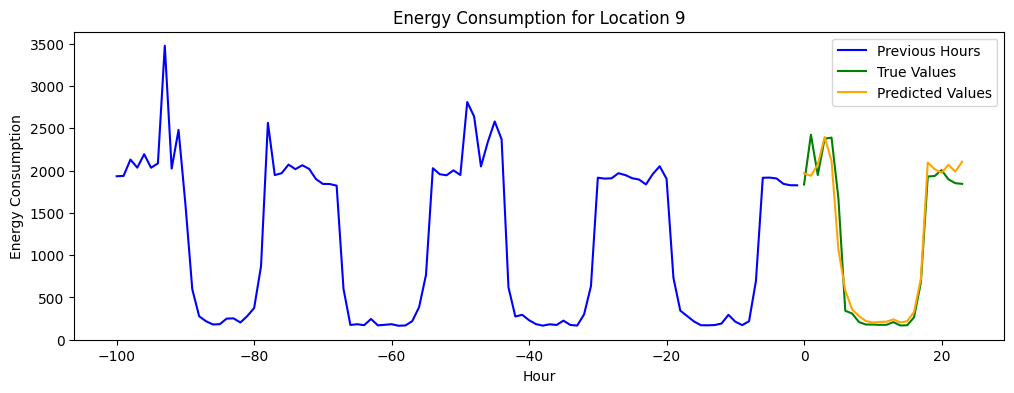

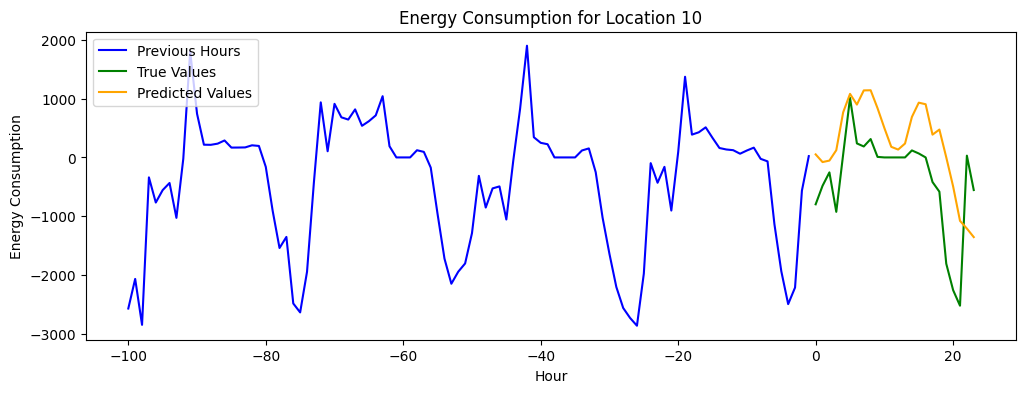

c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


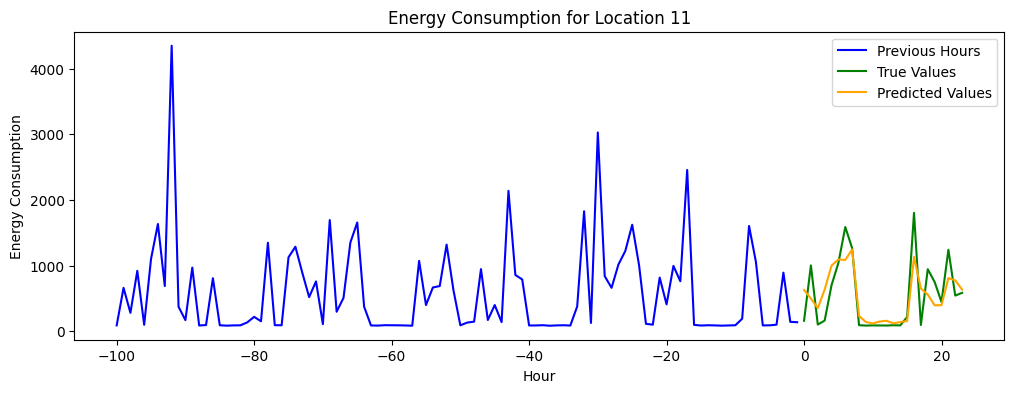

c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


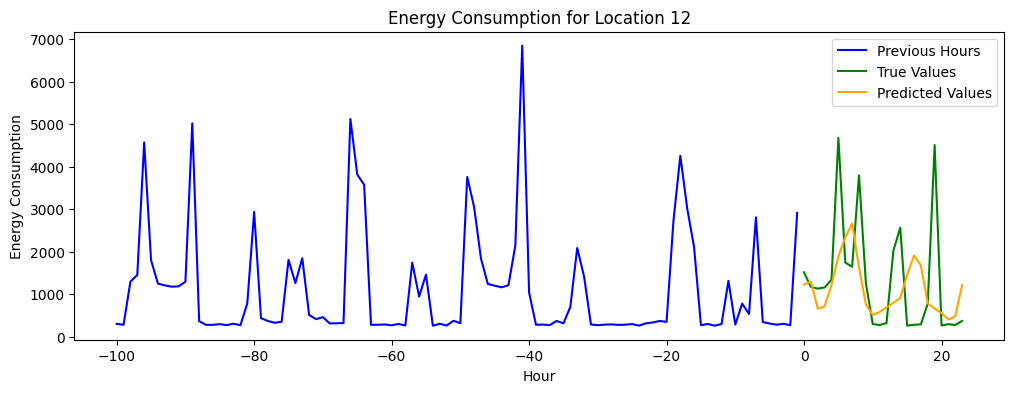

c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


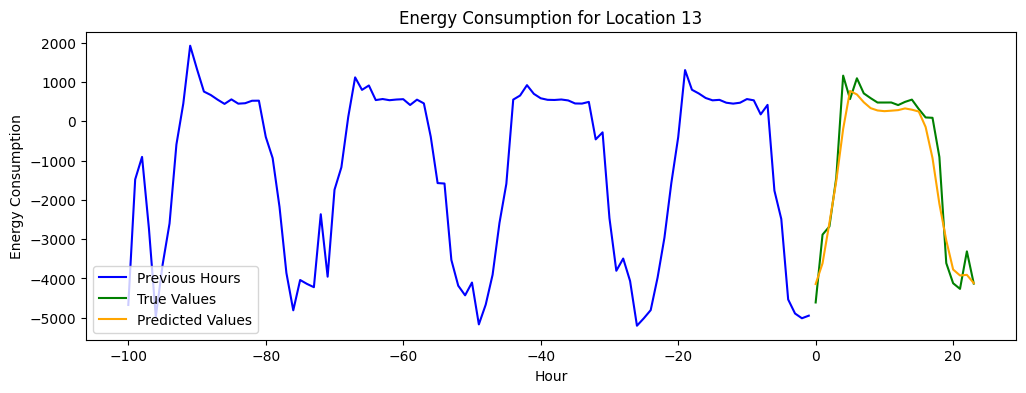

c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


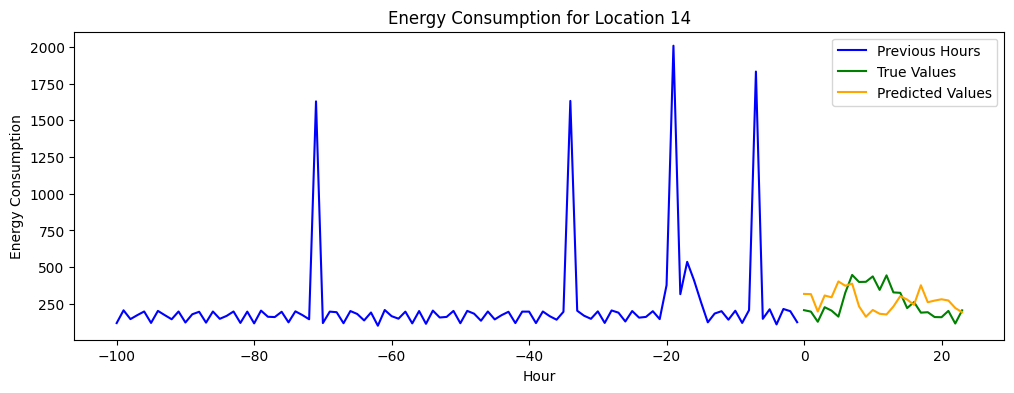

c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Installed_programs\Conda\envs\timeseries\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


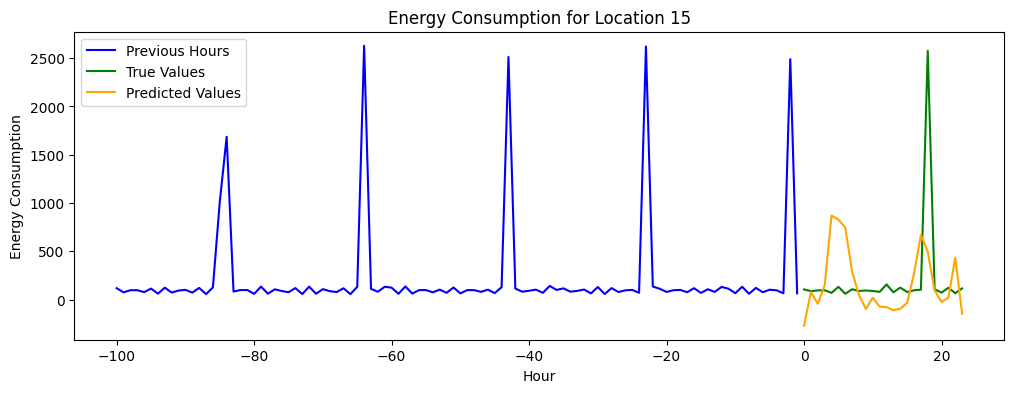

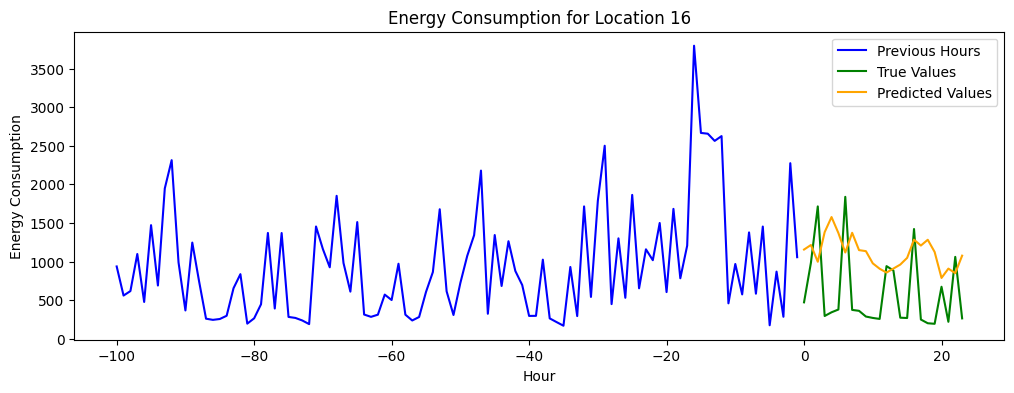

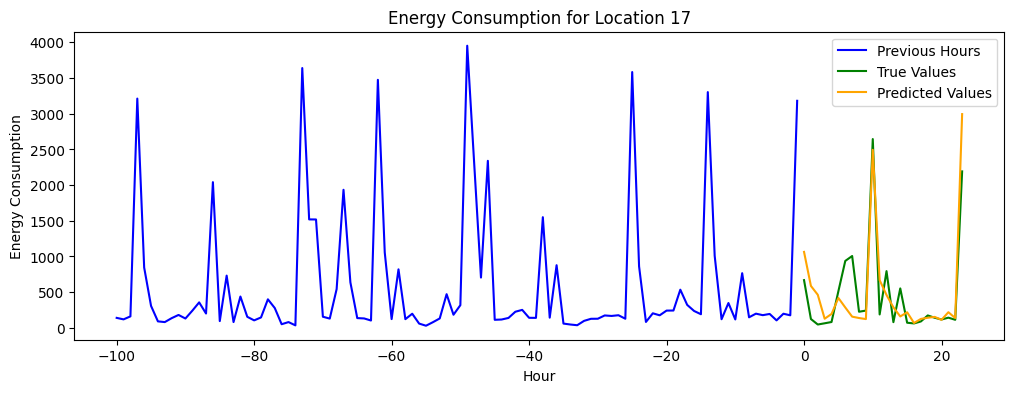

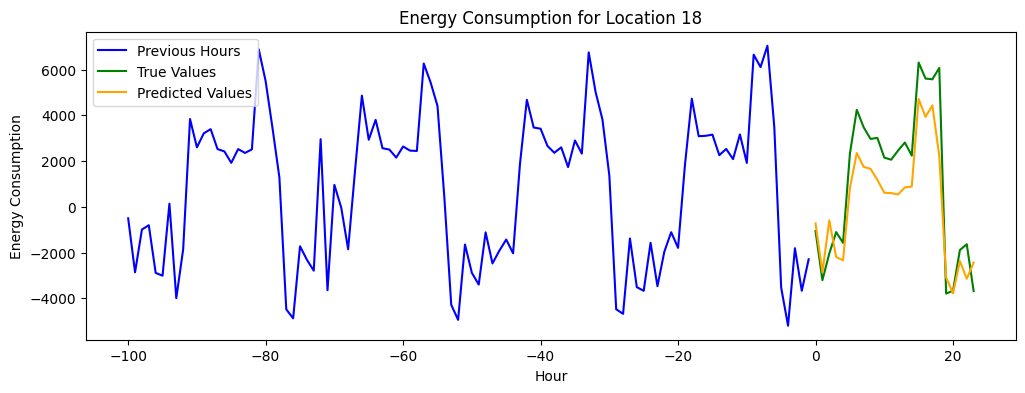

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA parameters
p, d, q = 2, 1, 2
P, D, Q, s = 1, 1, 1, 24  # Assuming a daily seasonality

models = []
mse_list = []
r2_list = []

def plot_sarima_prediction_for_locations(locations, data, n_previous=100, steps_ahead=24):
    train_size = int(0.8 * len(data))

    for location in locations:
        location_data = data.iloc[:, location]
        train, test = location_data[:train_size], location_data[train_size:]
        train = train[int(0.3 * len(train)):]
        # fit the SARIMA model and make predictions
        sarima_model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s)).fit()
        models.append(sarima_model)
        predictions = sarima_model.forecast(steps=24)

        # plot the predictions and true values
        
        previous_hours = train[-n_previous:]
        previous_hours_x = np.arange(-n_previous, 0)
        prediction_x = np.arange(0, steps_ahead)

        mse = mean_squared_error(test[:len(predictions)], predictions)
        r2 = r2_score(test[:len(predictions)], predictions)
        mse_list.append(mse)
        r2_list.append(r2)

        plt.figure(figsize=(12, 4))
        plt.plot(previous_hours_x, previous_hours, label='Previous Hours', color='blue')
        plt.plot(prediction_x, test[:steps_ahead], label='True Values', color='green')
        plt.plot(prediction_x, predictions[:steps_ahead], label='Predicted Values', color='orange')

        plt.xlabel('Hour')
        plt.ylabel('Energy Consumption')
        plt.title(f'Energy Consumption for Location {location}')
        plt.legend()
        plt.show()




locations = [i for i in range(19)]
plot_sarima_prediction_for_locations(locations, data)

average_mse = np.mean(mse_list)
r2 = np.mean(r2_list)

model_scores_list.append({"model_name": "multiple_SARIMA", "model_instance": models, "average_mse": average_mse, "r2": r2})


In [ ]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import TCNModel

# Load your dataset
data = df_nc_t.drop(columns=['Date', "e_pos_battery", "e_neg_battery", "e_pos_PCC", "e_neg_PCC", "e_pos_PCC_batt", "e_neg_PCC_batt"])

# Create a Darts TimeSeries object
time_series = TimeSeries.from_dataframe(data.reset_index(), 'index', data.columns)

# Split the time series into train and test sets
train_size = int(0.8 * len(time_series))
train, test = time_series.split_after(train_size)

# Create a TCN model instance
model = TCNModel(input_chunk_length=100, output_chunk_length=24, n_epochs=10, num_layers=6, num_filters=32)

# Train the model
model.fit(train)

# Make predictions
predictions = model.predict(24)  # Predict 24 time steps ahead

# Evaluate the model using Mean Squared Error (MSE) and R2 score
mse = mean_squared_error(test.values()[:, -24:], predictions.values())
r2 = r2_score(test.values()[:, -24:], predictions.values())

print("MSE:", mse)
print("R2 Score:", r2)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 61.3 K
----------------------------------------------------
61.3 K    Trainable params
0         Non-trainable params
61.3 K    Total params
0.245     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 415/415 [03:08<00:00,  2.20it/s, train_loss=2.65e+5]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 415/415 [03:08<00:00,  2.20it/s, train_loss=2.65e+5]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.58it/s]


ValueError: Found input variables with inconsistent numbers of samples: [3345, 24]

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score

num_locations = 19
mse_scores = []
r2_scores = []
models = []

data_for_prophet = data_with_date.set_index('Date')

for location in range(num_locations):
    print(f"Training model for location {location}")

    # Prepare location-specific data
    location_data = data_for_prophet.iloc[:, location].reset_index()
    location_data.columns = ['ds', 'y']
    
    location_data['ds'] = location_data['ds'].dt.tz_localize(None)

    # Split the data into train and test sets
    train_size = int(0.8 * len(location_data))
    train_data = location_data[:train_size]
    test_data = location_data[train_size:]

    # Create and fit the Prophet model
    model = Prophet()
    model.fit(train_data)
    models.append(model)

    # Make predictions
    future = model.make_future_dataframe(periods=len(test_data), freq='H')
    forecast = model.predict(future)
    predictions = forecast['yhat'][train_size:]

    # Calculate the MSE and R2 score
    mse = mean_squared_error(test_data['y'], predictions)
    r2 = r2_score(test_data['y'], predictions)

    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f"MSE for location {location}:", mse)
    print(f"R2 Score for location {location}:", r2)
    print("\n")

# Calculate mean scores
average_mse = np.mean(mse_scores)
r2 = np.mean(r2_scores)

print("Mean MSE:", average_mse)
print("Mean R2 Score:", r2)

model_scores_list.append({"model_name": "multiple_Prophets", "model_instance": models, "average_mse": average_mse, "r2": r2})


Training model for location 0


00:07:47 - cmdstanpy - INFO - Chain [1] start processing
00:07:52 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 0: 371877.6460302441
R2 Score for location 0: -0.3429926731259929


Training model for location 1


00:07:56 - cmdstanpy - INFO - Chain [1] start processing
00:07:58 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 1: 16165894.280694654
R2 Score for location 1: -1.8846106627324435


Training model for location 2


00:08:01 - cmdstanpy - INFO - Chain [1] start processing
00:08:03 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 2: 1361308.7844192297
R2 Score for location 2: -4.565378764022665


Training model for location 3


00:08:06 - cmdstanpy - INFO - Chain [1] start processing
00:08:08 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 3: 30447142.31614286
R2 Score for location 3: -2.46343341862338


Training model for location 4


00:08:12 - cmdstanpy - INFO - Chain [1] start processing
00:08:14 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 4: 2560333.732616243
R2 Score for location 4: 0.019911953049881914


Training model for location 5


00:08:17 - cmdstanpy - INFO - Chain [1] start processing
00:08:19 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 5: 5067663.208651135
R2 Score for location 5: -2.7867434814024166


Training model for location 6


00:08:23 - cmdstanpy - INFO - Chain [1] start processing
00:08:25 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 6: 8403894.480528314
R2 Score for location 6: -1.3468517011207712


Training model for location 7


00:08:28 - cmdstanpy - INFO - Chain [1] start processing
00:08:31 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 7: 679415.4967486896
R2 Score for location 7: -0.5736606159123327


Training model for location 8


00:08:34 - cmdstanpy - INFO - Chain [1] start processing
00:08:38 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 8: 200787.51679546223
R2 Score for location 8: -0.07969661975213715


Training model for location 9


00:08:42 - cmdstanpy - INFO - Chain [1] start processing
00:08:44 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 9: 1489906.7346505215
R2 Score for location 9: -1.0427836606623302


Training model for location 10


00:08:47 - cmdstanpy - INFO - Chain [1] start processing
00:08:50 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 10: 28497371.478775773
R2 Score for location 10: -1.4265444567876022


Training model for location 11


00:08:53 - cmdstanpy - INFO - Chain [1] start processing
00:08:55 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 11: 646839.1874232155
R2 Score for location 11: 0.09230570193443788


Training model for location 12


00:08:58 - cmdstanpy - INFO - Chain [1] start processing
00:09:01 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 12: 26939183.25654282
R2 Score for location 12: -6.642297128359564


Training model for location 13


00:09:04 - cmdstanpy - INFO - Chain [1] start processing
00:09:06 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 13: 9789767.332586357
R2 Score for location 13: -1.8760890180607528


Training model for location 14


00:09:10 - cmdstanpy - INFO - Chain [1] start processing
00:09:12 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 14: 2405126.9401205173
R2 Score for location 14: -6.688982385842387


Training model for location 15


00:09:16 - cmdstanpy - INFO - Chain [1] start processing
00:09:19 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 15: 3902716.099030207
R2 Score for location 15: -2.374250696955351


Training model for location 16


00:09:22 - cmdstanpy - INFO - Chain [1] start processing
00:09:28 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 16: 5900123.754236757
R2 Score for location 16: -3.3054071191663246


Training model for location 17


00:09:31 - cmdstanpy - INFO - Chain [1] start processing
00:09:33 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 17: 1817300.007246624
R2 Score for location 17: -0.930609659338332


Training model for location 18


00:09:38 - cmdstanpy - INFO - Chain [1] start processing
00:09:41 - cmdstanpy - INFO - Chain [1] done processing


MSE for location 18: 122107312.06599243
R2 Score for location 18: -1.4494536464769494


Mean MSE: 14144945.490485897
Mean R2 Score: -2.08776673965039


In [ ]:
for model in model_scores_list:
    print(model["model_name"], "ME:", np.sqrt(model["average_mse"]), "R2:", model["r2"])

multi_output_LSTM ME: 2383.541421509016 R2: -0.17102765072914905
multi_output_convolutional ME: 2312.1981124080794 R2: -0.20923290855127025
hierarchical_convolutional ME: 2486.929193606394 R2: -0.10283293410882906
multiple_LSTMs ME: 2143.8650488638164 R2: 0.00248967126240123
hierarchical_temporal_convolutional ME: 2195.5260772555202 R2: 0.04378049360388517
multiple_SARIMA ME: 691.6145427784647 R2: 0.26493882921443596


In [ ]:

for key, value in data.items():
    print(f"{key}: {value}")

e_pos_neg_sum_0: 0         485.0
1         218.0
2         224.0
3         287.0
4         227.0
          ...  
16722     262.0
16723    1037.0
16724     948.0
16725     215.0
16726     240.0
Name: e_pos_neg_sum_0, Length: 16727, dtype: float64
e_pos_neg_sum_1: 0         810.0
1        1433.0
2        2046.0
3        1688.0
4        1762.0
          ...  
16722    2515.0
16723    2458.0
16724     637.0
16725     464.0
16726     778.0
Name: e_pos_neg_sum_1, Length: 16727, dtype: float64
e_pos_neg_sum_2: 0        1862.0
1        1679.0
2        1749.0
3        1879.0
4        1998.0
          ...  
16722    2251.0
16723    1263.0
16724    1235.0
16725    1191.0
16726    1054.0
Name: e_pos_neg_sum_2, Length: 16727, dtype: float64
e_pos_neg_sum_3: 0        2469.0
1        2330.0
2        2457.0
3        2123.0
4        4850.0
          ...  
16722    2948.0
16723    3406.0
16724    2146.0
16725    1159.0
16726    1243.0
Name: e_pos_neg_sum_3, Length: 16727, dtype: float64
e_pos_neg_sum_4:

In [ ]:
# Define the LinearForecaster model
class LinearForecaster:
    def __init__(self):
        self.theta = None
        self.target_cols = None

    def fit(self, X, y):
        self.target_cols = y.columns
        self.theta = np.linalg.pinv(X.values.T@X.values)@(X.values.T@y.values)
        return self
    
    def predict(self, X):
        preds = X.values @ self.theta
        return pd.DataFrame(preds, index=X.index, columns=self.target_cols)       

In [ ]:
def get_hankel(df, embedding=3):
    dfs = {}
    for c in df.columns:
        df_i = pd.concat([df[[c]].shift(-l) for l in range(embedding)], axis=1).iloc[:-embedding]
        df_i.columns = [i for i in range(df_i.shape[1])]
        dfs[c] = df_i
    return pd.concat(dfs, axis=1)

In [ ]:
df_trial = pd.DataFrame()
df_trial['e_pos'] = df[(0, 'e_pos')]
# df_trial.index.names = ['datetime']
df_trial.head()

KeyError: (0, 'e_pos')

In [ ]:
# Compute training and testing sets

train_period = 24*5  # Train on 5 days
tr_ratio = 0.75

forecast_periods = [train_period-i for i in range(1, 25)]
period_name = ['1h', '2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', '10h', '11h', '12h', '13h', '14h', '15h', '16h', '17h', '18h', '19h', '20h', '21h', '22h', '23h', '24h']

train_test_splits = {}

for f_period_name, forecast_period in zip(period_name, forecast_periods):
    # print(f'Forecast period: {f_period_name}')
    # print(f'Forecast period length: {forecast_period} hours')
    df_emb = get_hankel(df_trial, embedding = train_period)
    x = df_emb.loc[:, df_emb.columns.get_level_values(1) < forecast_period]
    y = df_emb.loc[:, df_emb.columns.get_level_values(1) >= forecast_period]

    n_tr = int(len(x) * tr_ratio)
    X_train, X_test = x.iloc[:n_tr, :], x.iloc[n_tr:, :]
    y_train, y_test = y.iloc[:n_tr, :], y.iloc[n_tr:, :]

    train_test_splits[f'{f_period_name}'] = [X_train, y_train, X_test, y_test]

In [ ]:
# Train multiple Linear regresssion models on the different datasets, and save results
scores = {}
for split_name, train_test in train_test_splits.items():
    # Train a linear regression model
    lr = LinearForecaster()
    lr.fit(train_test[0], train_test[1])
    y_train_pred_lr = lr.predict(train_test[0])
    y_test_pred_lr = lr.predict(train_test[2])

    # List of scores, in order: [RMSE, R2]
    score_string = f'Linear {split_name}'

    scores[score_string] = [mean_squared_error(train_test[3], y_test_pred_lr, squared=False), 
                                        r2_score(train_test[3], y_test_pred_lr)]

    # Print results for the different models
    # print(f'Linear {split_name} scores:')
    # print(f'Training RMSE: {mean_squared_error(train_test[1], y_train_pred_lr, squared=False):.2f}')
    # print(f'Testing RMSE: {scores[f"{score_string}"][0]:.2f}')
    # print(f'Training R2: {r2_score(train_test[1], y_train_pred_lr):.2f}')
    # print(f'Testing R2: {scores[f"{score_string}"][1]:.2f}')
    # print('-'*50, '\n')

In [ ]:
# TODO - terminate the multivariate linear regression model

In [ ]:
df.head()

In [ ]:
# Define embeddings for the different datasets and forecast periods
for f_period_name, forecast_period in forecast_periods.items():
    # Compute training and testing sets
    df_emb = get_hankel(df, embedding = train_period)
    x = df_emb.loc[:, df_emb.columns.get_level_values(1) < forecast_period]
    x["dayminute"] = np.sin((x.index.hour * 60 + x.index.minute) / (1410) * 2 * np.pi - np.pi)/2
    x["dayofyear"] = x.index.dayofyear / 365
    
    y = df_emb.loc[:, df_emb.columns.get_level_values(1) >= forecast_period]['PM10']

    n_tr = int(len(x) * tr_ratio)
    X_train, X_test = x.iloc[:n_tr, :], x.iloc[n_tr:, :]
    y_train, y_test = y.iloc[:n_tr, :], y.iloc[n_tr:, :]

    train_test_splits[f'{df_name} {f_period_name}'] = [X_train, y_train, X_test, y_test]

# Model selection

In [ ]:
# Preprocess the data
# You can apply any additional preprocessing steps based on your dataset's requirements
scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[df.columns.levels[0] == 'general'] = scaler.fit_transform(df[df.columns.levels[0] == 'general'])

# Split the data into training and validation sets
train_df, val_df = train_test_split(scaled_df, test_size=0.2, shuffle=False, random_state=42)

# Bottom-up hierarchical modeling
# Train individual models for each station's epos and eneg values
models = {}
for station in df.columns.levels[1]:
    for variable in ['epos', 'eneg']:
        X_train = train_df.loc[:, ('general', 'general')].values
        y_train = train_df.loc[:, (slice(None), station, variable)].values.ravel()

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        models[(station, variable)] = model

# Validate the models on the validation set
X_val = val_df.loc[:, ('general', 'general')].values
y_val_true = val_df.loc[:, (slice(None), slice(None), ['epos', 'eneg'])].values.reshape(-1)
y_val_pred = np.zeros_like(y_val_true)

for i, (station, variable) in enumerate(models.keys()):
    model = models[(station, variable)]
    y_val_pred[i::len(models)] = model.predict(X_val)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val_true, y_val_pred)
print(f'Mean Absolute Error: {mae:.2f}')
